In [ ]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

file_path = '/content/drive/MyDrive/NLPDATA/NewsBiasDataset.csv'
df = pd.read_csv(file_path)

df.head()

Mounted at /content/drive


Title  \
0  Steve Kornacki to Exit MSNBC For NBC as SpinCo...   
1  Jon Richardson swaps comedy circuit for the cl...   
2  We didn't expect to find such a beautiful, thr...   
3                              About That Third Term   
4  Wall Street increases range of estimated new c...   

                                                Body        News Source Name  \
0  One of MSNBC‘s election night stalwarts is jum...  The Hollywood Reporter   
1  Triple H and Stephanie McMahon 's love story b...                BBC News   
2  Shares of Newsmax kept climbing ahead of their...            Live Science   
3  In the ever-turbulent arena of American politi...                Townhall   
4  • Italian automaker Ferrari has said it will i...      Detroit Free Press   

                                      Tags  \
0                                 Business   
1     Arts And Entertainment,Entertainment   
2                              ESG,Science   
3  Donald Trump,Third Term,US Constitution   
4              Markets,Banking and Finance   

                                             Authors  \
0  Alex Weprin, .Wp-Block-Co-Authors-Plus-Coautho...   
1                                                NaN   
2                                                NaN   
3                  Kevin Mccullough, Kurt Schlichter   
4                                                NaN   

                                           Main Text         bias  agree_ratio  
0  One of MSNBC‘s election night stalwarts is jum...  left-center     1.039216  
1  The BBC has announced that comedian and TV per...       center     1.165914  
2  A gigantic iceberg that broke off of an Antarc...       center     1.295775  
3  In the ever-turbulent arena of American politi...        right     0.690673  
4  Italian automaker Ferrari has said it will inc...  left-center     0.840000

[I 2025-05-14 01:04:08,476] A new study created in memory with name: no-name-6ea94c12-ed47-4750-a5d6-77762a0347e3
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[W 2025-05-14 01:07:58,951] Trial 0 failed with parameters: {'learning_rate': 1.1101091202945567e-05, 'batch_size': 8, 'weight_decay': 0.09445692879147212, 'warmup_steps': 400} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-6-c74c92cf5ea7>", line 1126, in objective
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2245, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2565, in _inner_training_loop
    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-05-14 01:07:58,953] Trial 0 failed with value None.


KeyboardInterrupt: 

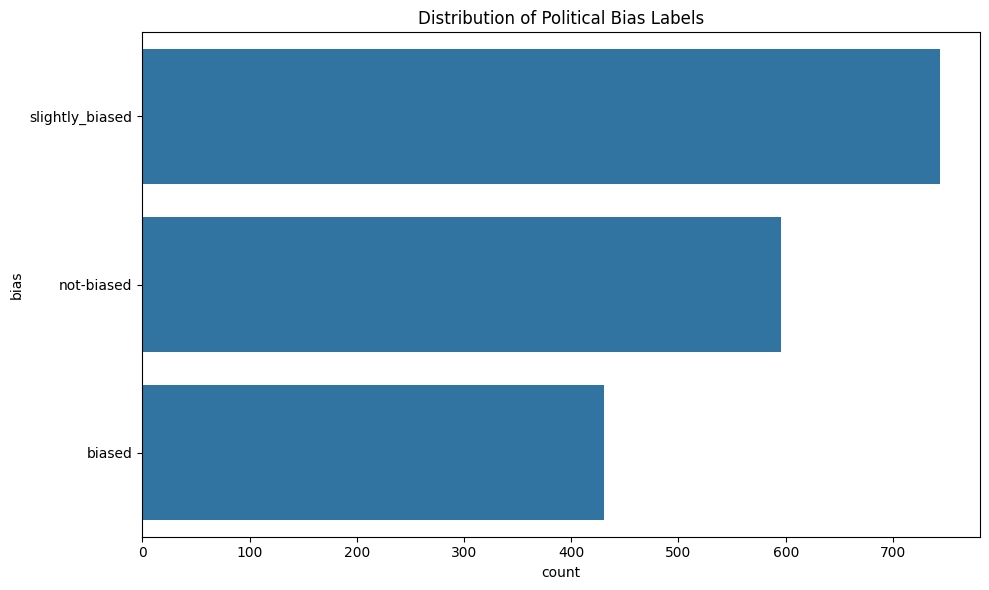

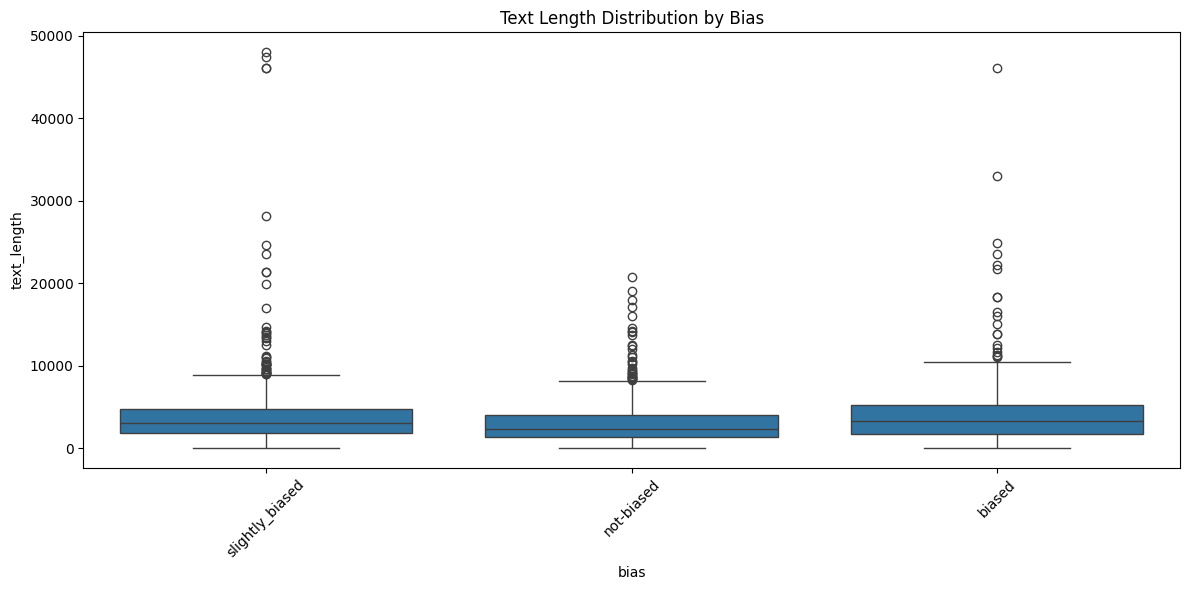

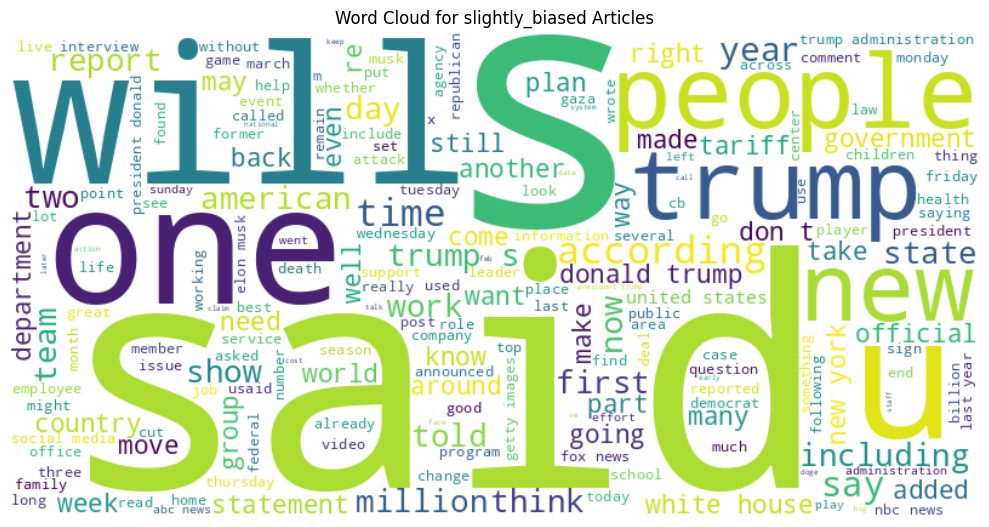

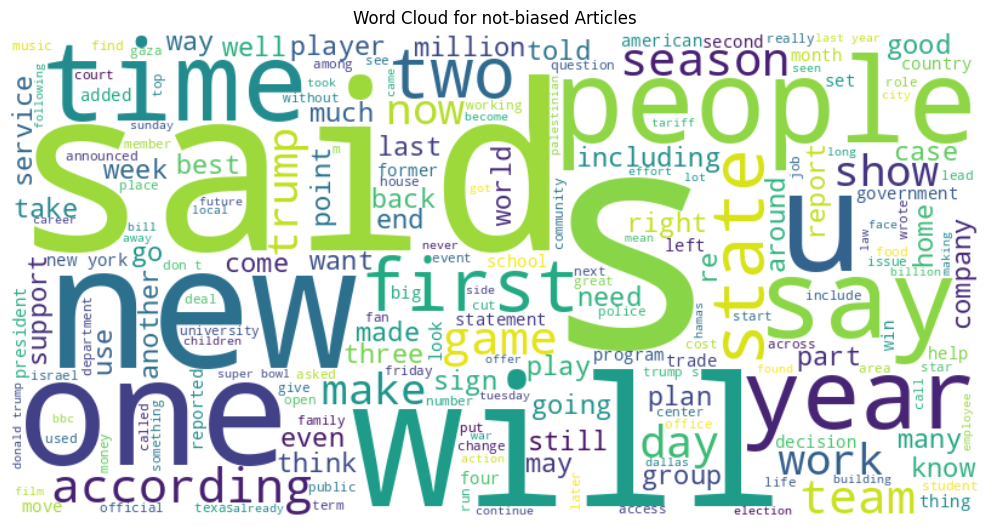

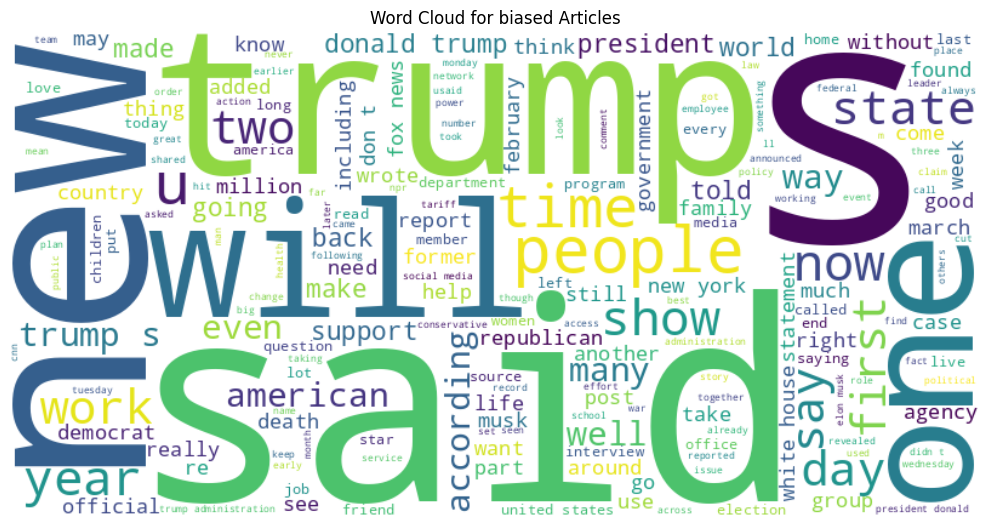

In [ ]:
"""
News Bias Classification Pipeline

This script implements a complete pipeline for classifying news articles based on their political bias.
Following the structured approach from the project outline with stages and checkpoints.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import warnings
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import random
import os
import logging
import json
from datetime import datetime

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("news_bias_classifier.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)




class NewsBiasClassifier:
    """
    End-to-end pipeline for classifying news articles based on political bias.
    """

    def __init__(self, config=None):
        """
        Initialize the classifier with configuration settings.

        Args:
            config (dict): Configuration parameters for the pipeline
        """
        # Default configuration
        self.default_config = {
            'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
            'random_seed': RANDOM_SEED,
            'model_type': 'bert',
            'bert_model': 'distilbert-base-uncased',  # Still a good fast baseline
            'max_length': 256,  # 512 is often excessive unless your articles are very long
            'batch_size': 8,  # Smaller batch sizes often help avoid OOM and improve generalization
            'learning_rate': 3e-5,  # Good BERT range: 2e-5 to 5e-5
            'epochs': 15,  # 3–5 is typically enough to converge on small/medium datasets
            'warmup_steps': 100,  # Optional but useful for stability
            'weight_decay': 0.01,  # Regularization to reduce overfitting
            'class_weights': True,

            'tfidf_params': {
                'max_features': 10000,
                'min_df': 5,
                'max_df': 0.8,
                'ngram_range': (1, 2)
            },
            'logreg_params': {
                'C': 1.0,
                'max_iter': 1000,
                'class_weight': 'balanced'
            },
            'experiment_name': f"news_bias_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        }


        # Update with user config if provided
        self.config = self.default_config.copy()
        if config:
            self.config.update(config)

        # Initialize pipeline components
        self.model = None
        self.vectorizer = None
        self.label_encoder = None
        self.experiment_results = {}

        logger.info(f"Initialized NewsBiasClassifier with config: {self.config}")

    def preprocess_text(self, text):
        """
        Clean and preprocess text data.

        Args:
            text (str): Raw text

        Returns:
            str: Cleaned text
        """
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        text = re.sub(r'Advertisement', '', text)
        text = re.sub(r'advertisement', '', text)
        text = re.sub(r'More information', '', text)
        text = re.sub(r'more information', '', text)

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def load_and_prepare_data(self, df):
        """
        Load data, perform EDA, and prepare datasets for training.

        Args:
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Dictionary containing train, validation, and test datasets
        """
        logger.info("Starting data preparation...")

        # Make a copy to avoid modifying the original dataframe
        data = df.copy()

        # Check for missing values
        missing_values = data.isnull().sum()
        logger.info(f"Missing values in dataset:\n{missing_values}")

        # Filter out rows with missing Main Text
        original_size = len(data)
        data = data.dropna(subset=['Main Text'])
        logger.info(f"Dropped {original_size - len(data)} rows with missing Main Text")

        # Convert bias labels to categories if needed
        if 'bias' in data.columns:
            # Check bias distribution
            bias_distribution = data['bias'].value_counts()
            logger.info(f"Bias label distribution:\n{bias_distribution}")

            # Create numerical encoding for bias labels
            unique_biases = data['bias'].unique()
            self.bias_categories = {bias: idx for idx, bias in enumerate(unique_biases)}
            data['bias_encoded'] = data['bias'].map(self.bias_categories)

            # Keep track of the mapping for interpretation
            self.idx_to_bias = {idx: bias for bias, idx in self.bias_categories.items()}

            logger.info(f"Encoded bias categories: {self.bias_categories}")

        # Preprocess text
        logger.info("Preprocessing text data...")
        data['processed_text'] = data['Main Text'].apply(self.preprocess_text)

        # Check text length distribution
        data['text_length'] = data['processed_text'].apply(len)

        # Split data
        train_val, test = train_test_split(
            data,
            test_size=self.config['data_split']['test'],
            random_state=self.config['random_seed'],
            stratify=data['bias_encoded'] if 'bias_encoded' in data.columns else None
        )

        train, val = train_test_split(
            train_val,
            test_size=self.config['data_split']['val'] / (self.config['data_split']['train'] + self.config['data_split']['val']),
            random_state=self.config['random_seed'],
            stratify=train_val['bias_encoded'] if 'bias_encoded' in train_val.columns else None
        )

        logger.info(f"Data split sizes - Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

        return {
            'train': train,
            'val': val,
            'test': test,
            'full_data': data
        }

    def perform_eda(self, data):
        """
        Perform Exploratory Data Analysis on the dataset.

        Args:
            data (dict): Dictionary containing data splits

        Returns:
            dict: EDA results and visualizations
        """
        logger.info("Performing Exploratory Data Analysis...")

        full_data = data['full_data']

        eda_results = {
            'dataset_info': {
                'total_samples': len(full_data),
                'bias_distribution': full_data['bias'].value_counts().to_dict() if 'bias' in full_data.columns else None,
                'text_length_stats': {
                    'mean': full_data['text_length'].mean(),
                    'median': full_data['text_length'].median(),
                    'min': full_data['text_length'].min(),
                    'max': full_data['text_length'].max()
                }
            }
        }

        logger.info(f"Dataset info:\n{json.dumps(eda_results['dataset_info'], indent=2)}")

        # Generate visualizations
        if 'bias' in full_data.columns:
            # Plot bias distribution
            plt.figure(figsize=(10, 6))
            sns.countplot(y='bias', data=full_data)
            plt.title('Distribution of Political Bias Labels')
            plt.tight_layout()
            plt.savefig('bias_distribution.png')

            # Plot text length by bias
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='bias', y='text_length', data=full_data)
            plt.title('Text Length Distribution by Bias')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('text_length_by_bias.png')

            # Generate word clouds by bias category
            for bias in full_data['bias'].unique():
                bias_text = ' '.join(full_data[full_data['bias'] == bias]['processed_text'])
                if bias_text.strip():  # Ensure there's text to process
                    wc = WordCloud(width=800, height=400, background_color='white', max_words=200)
                    wc.generate(bias_text)

                    plt.figure(figsize=(10, 6))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud for {bias} Articles')
                    plt.tight_layout()
                    plt.savefig(f'wordcloud_{bias.replace(" ", "_")}.png')

        logger.info("EDA completed and visualizations saved")
        return eda_results

    def build_tfidf_logreg_model(self):
        """
        Build a TF-IDF + Logistic Regression pipeline.

        Returns:
            sklearn.pipeline.Pipeline: Model pipeline
        """
        logger.info("Building TF-IDF + Logistic Regression model...")

        # Create TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            max_features=self.config['tfidf_params']['max_features'],
            min_df=self.config['tfidf_params']['min_df'],
            max_df=self.config['tfidf_params']['max_df'],
            ngram_range=self.config['tfidf_params']['ngram_range'],
            stop_words='english'
        )

        # Create logistic regression model
        logreg = LogisticRegression(
            C=self.config['logreg_params']['C'],
            max_iter=self.config['logreg_params']['max_iter'],
            class_weight=self.config['logreg_params']['class_weight'] if self.config['class_weights'] else None,
            random_state=self.config['random_seed']
        )

        # Create pipeline
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('logreg', logreg)
        ])

        return pipeline

    def build_bert_model(self, num_labels):
        """
        Build a BERT-based model for text classification.

        Args:
            num_labels (int): Number of target classes

        Returns:
            tuple: (tokenizer, model) for the BERT-based classifier
        """
        logger.info(f"Building BERT model ({self.config['bert_model']})...")

        # Load pre-trained tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])
        model = AutoModelForSequenceClassification.from_pretrained(
            self.config['bert_model'],
            num_labels=num_labels
        )

        return tokenizer, model

    def train_tfidf_logreg(self, train_data, val_data):
        """
        Train and evaluate the TF-IDF + Logistic Regression model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, evaluation_results)
        """
        logger.info("Training TF-IDF + Logistic Regression model...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Build and train the model
        model = self.build_tfidf_logreg_model()
        model.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        classification_rep = classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()), output_dict=True)
        conf_matrix = confusion_matrix(y_val, y_pred)

        # Log results
        logger.info(f"Validation Accuracy: {accuracy:.4f}")
        logger.info(f"Validation F1 Score (macro): {f1:.4f}")
        logger.info(f"Classification Report:\n{classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()))}")

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('tfidf_logreg_confusion_matrix.png')

        # Return the trained model and evaluation results
        results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': classification_rep,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, results

    def train_bert(self, train_data, val_data):
        """
        Train and evaluate the BERT-based model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, tokenizer, evaluation_results)
        """
        logger.info("Training BERT model...")

        # Prepare the tokenizer and model
        num_labels = len(self.bias_categories)
        tokenizer, model = self.build_bert_model(num_labels)

        # Prepare the datasets
        class NewsDataset(torch.utils.data.Dataset):
            def __init__(self, texts, labels, tokenizer, max_length):
                self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        # Create datasets
        train_dataset = NewsDataset(
            train_data['processed_text'].tolist(),
            train_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        val_dataset = NewsDataset(
            val_data['processed_text'].tolist(),
            val_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        # Compute class weights for handling imbalance
        if self.config['class_weights']:
            class_counts = train_data['bias_encoded'].value_counts().sort_index()
            total_samples = len(train_data)
            class_weights = torch.tensor(
                [total_samples / (len(class_counts) * count) for count in class_counts],
                dtype=torch.float
            )
            logger.info(f"Class weights: {class_weights}")
        else:
            class_weights = None

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/{self.config['experiment_name']}",
            num_train_epochs=self.config['epochs'],
            per_device_train_batch_size=self.config['batch_size'],
            per_device_eval_batch_size=self.config['batch_size'],
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            learning_rate=self.config['learning_rate'],
        )

        # Define compute metrics function
        def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            f1 = f1_score(labels, preds, average='macro')
            acc = accuracy_score(labels, preds)
            return {'accuracy': acc, 'f1': f1}

        # Create trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        eval_results = trainer.evaluate()
        logger.info(f"Evaluation results: {eval_results}")

        # Make predictions for confusion matrix
        val_predictions = trainer.predict(val_dataset)
        y_pred = np.argmax(val_predictions.predictions, axis=1)
        y_true = val_data['bias_encoded'].values

        # Calculate detailed metrics
        class_report = classification_report(
            y_true, y_pred,
            target_names=list(self.bias_categories.keys()),
            output_dict=True
        )
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('BERT Model Confusion Matrix')
        plt.tight_layout()
        plt.savefig('bert_confusion_matrix.png')

        # Return results
        results = {
            'accuracy': eval_results['eval_accuracy'],
            'f1_score': eval_results['eval_f1'],
            'classification_report': class_report,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, tokenizer, results

    def hyperparameter_tuning(self, train_data, val_data):
        """
        Perform hyperparameter tuning for the TF-IDF + LogReg model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            dict: Best parameters and results
        """
        logger.info("Starting hyperparameter tuning for TF-IDF + LogReg...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Define parameter grid
        param_grid = {
            'tfidf__max_features': [5000, 10000, 15000],
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'logreg__C': [0.1, 1.0, 10.0]
        }

        # Build base model
        model = self.build_tfidf_logreg_model()

        # Set up grid search with cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.config['random_seed'])
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=cv,
            scoring='f1_macro',
            verbose=1,
            n_jobs=-1
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        logger.info(f"Best CV score: {best_score:.4f}")
        logger.info(f"Best parameters: {best_params}")

        # Evaluate best model on validation set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)

        val_accuracy = accuracy_score(y_val, y_pred)
        val_f1 = f1_score(y_val, y_pred, average='macro')

        logger.info(f"Validation Accuracy with best model: {val_accuracy:.4f}")
        logger.info(f"Validation F1 Score with best model: {val_f1:.4f}")

        # Update config with best parameters
        for param, value in best_params.items():
            component, parameter = param.split('__')
            if component == 'tfidf':
                self.config['tfidf_params'][parameter] = value
            elif component == 'logreg':
                self.config['logreg_params'][parameter] = value

        tuning_results = {
            'best_params': best_params,
            'best_cv_score': best_score,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        }

        return best_model, tuning_results

    def evaluate_model(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
        """
        Evaluate the trained model on the test set.

        Args:
            model: Trained model
            test_data (pandas.DataFrame): Test dataset
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            dict: Evaluation metrics
        """
        logger.info(f"Evaluating {model_type} model on test data...")

        X_test = test_data['processed_text']
        y_test = test_data['bias_encoded']

        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)

        elif model_type == 'bert':
            # For BERT model

            # Create dataset
            class NewsDataset(torch.utils.data.Dataset):
                def __init__(self, texts, labels, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                    self.labels = labels

                def __getitem__(self, idx):
                    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                    item['labels'] = torch.tensor(self.labels[idx])
                    return item

                def __len__(self):
                    return len(self.labels)

            test_dataset = NewsDataset(
                X_test.tolist(),
                y_test.tolist(),
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            test_predictions = trainer.predict(test_dataset)

            y_prob = test_predictions.predictions
            y_pred = np.argmax(y_prob, axis=1)

        # Create combined dataframe with predictions
        analysis_df = test_data.copy()
        analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
        analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
        analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

        # Find confident correct and incorrect predictions
        if model_type == 'tfidf_logreg':
            analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
        else:
            analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

        high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
        low_conf_predictions = analysis_df[analysis_df['confidence'] < 0.6]

        # Analyze potentially neutral articles
        neutral_predictions = []
        if model_type == 'tfidf_logreg':
            # If max probability is low across all classes, the article might be neutral
            for i, probs in enumerate(y_prob):
                if np.max(probs) < 0.4:  # Low confidence threshold
                    neutral_predictions.append({
                        'index': i,
                        'text': test_data.iloc[i]['Main Text'][:300] + '...',
                        'predicted_bias': self.idx_to_bias[y_pred[i]],
                        'true_bias': self.idx_to_bias[y_test.iloc[i]],
                        'confidence': np.max(probs),
                        'all_probs': {self.idx_to_bias[j]: prob for j, prob in enumerate(probs)}
                    })

        # Return qualitative analysis results
        results = {
            'general_stats': {
                'accuracy': (analysis_df['correct'].sum() / len(analysis_df)),
                'high_conf_predictions': len(analysis_df[analysis_df['confidence'] > 0.8]),
                'low_conf_predictions': len(analysis_df[analysis_df['confidence'] < 0.6]),
            },
            'examples': {
                'high_conf_correct': high_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'high_conf_incorrect': high_conf_incorrect.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'low_conf_correct': low_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'potential_neutral': neutral_predictions[:3] if neutral_predictions else []
            }
        }

        # Log summary of findings
        logger.info("Qualitative Analysis Summary:")
        logger.info(f"  - {results['general_stats']['high_conf_predictions']} high confidence predictions (>0.8)")
        logger.info(f"  - {results['general_stats']['low_conf_predictions']} low confidence predictions (<0.6)")
        logger.info(f"  - {len(high_conf_incorrect)} predictions that are highly confident but wrong")
        logger.info(f"  - Found {len(neutral_predictions)} potentially neutral articles")

        return results

    def feature_importance(self, model, model_type='tfidf_logreg'):
        """
        Extract and analyze feature importance from the model

        Args:
            model: Trained model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            dict: Feature importance analysis
        """
        if model_type != 'tfidf_logreg':
            logger.info("Feature importance analysis is only available for TF-IDF + LogReg models")
            return None

        logger.info("Analyzing feature importance...")

        # Extract the vectorizer and classifier from the pipeline
        vectorizer = model.named_steps['tfidf']
        classifier = model.named_steps['logreg']

        # Get feature names from the vectorizer
        feature_names = vectorizer.get_feature_names_out()

        # For each class, get the most important features
        important_features = {}

        for class_id, class_name in self.idx_to_bias.items():
            # Get coefficients for this class
            if classifier.coef_.shape[0] > 1:  # multi-class case
                coefficients = classifier.coef_[class_id]
            else:  # binary case
                coefficients = classifier.coef_[0] * (1 if class_id == 1 else -1)

            # Get top positive and negative features
            top_positive_indices = np.argsort(coefficients)[-20:]
            top_negative_indices = np.argsort(coefficients)[:20]

            top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
            top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

            important_features[class_name] = {
                'top_positive': top_positive,
                'top_negative': top_negative
            }

            # Log important features
            logger.info(f"Most important features for class '{class_name}':")
            logger.info("  Top positive features:")
            for feature, coef in top_positive[::-1]:
                logger.info(f"    {feature}: {coef:.4f}")

            logger.info("  Top negative features:")
            for feature, coef in top_negative:
                logger.info(f"    {feature}: {coef:.4f}")

        # Visualize top features for each class
        for class_name, features in important_features.items():
            plt.figure(figsize=(12, 8))

            # Plot positive features
            pos_features = features['top_positive']
            pos_features.sort(key=lambda x: x[1])
            plt.barh(
                [f[0] for f in pos_features],
                [f[1] for f in pos_features],
                color='green',
                alpha=0.7
            )

            plt.title(f'Top Features for "{class_name}" Class')
            plt.xlabel('Coefficient Value')
            plt.tight_layout()
            plt.savefig(f'feature_importance_{class_name.replace(" ", "_")}.png')

        return important_features

    def run_experiment(self, experiment_config, df):
        """
        Run a complete experiment with the given configuration.

        Args:
            experiment_config (dict): Configuration for the experiment
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Experiment results
        """
        # Update configuration
        self.config.update(experiment_config)
        exp_name = self.config['experiment_name']
        logger.info(f"Starting experiment: {exp_name}")

        # Step 1: Load and prepare data
        data_splits = self.load_and_prepare_data(df)

        # Step 2: Perform EDA
        eda_results = self.perform_eda(data_splits)

        # Step 3: Train model
        if self.config['model_type'] == 'tfidf_logreg':
            # [Existing TF-IDF + LogReg code...]
            pass

        elif self.config['model_type'] == 'bert':
            # Optional: Hyperparameter tuning for BERT
            if experiment_config.get('perform_tuning', False):
                model, tokenizer, tuning_results = self.hyperparameter_tuning_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'tuning_results': tuning_results
                }
            else:
                # Regular BERT training
                model, tokenizer, train_results = self.train_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'training_results': train_results
                }

            # Evaluate on test set
            test_results = self.evaluate_model(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['test_evaluation'] = test_results

            # Qualitative analysis
            qual_results = self.qualitative_analysis(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['qualitative_analysis'] = qual_results

        # Save experiment results
        self.experiment_results[exp_name] = results

        # Save model and results
        self._save_experiment(exp_name, model, results)

        logger.info(f"Experiment {exp_name} completed")
        return results

    def _save_experiment(self, exp_name, model, results):
        """
        Save experiment model and results to disk.

        Args:
            exp_name (str): Name of the experiment
            model: Trained model
            results (dict): Experiment results
        """
        # Create directory
        os.makedirs(f"./experiments/{exp_name}", exist_ok=True)

        # Save results as JSON
        with open(f"./experiments/{exp_name}/results.json", 'w') as f:
            json.dump(results, f, indent=2, default=lambda x: str(x))

        # Save config
        with open(f"./experiments/{exp_name}/config.json", 'w') as f:
            json.dump(self.config, f, indent=2)

        # Save model
        if results['model_type'] == 'tfidf_logreg':
            import joblib
            joblib.dump(model, f"./experiments/{exp_name}/model.joblib")
        else:
            # For BERT, save the model using transformers
            model.save_pretrained(f"./experiments/{exp_name}/model")

        logger.info(f"Saved experiment {exp_name} to disk")

    def predict(self, texts, model=None, model_type=None, tokenizer=None):
        """
        Make predictions on new texts.

        Args:
            texts (list): List of text strings to predict
            model: Model to use for prediction (if None, use the last trained model)
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            list: Predicted bias labels and probabilities
        """
        # Use current model and type if not provided
        if model is None:
            model = self.model

        if model_type is None:
            model_type = self.config['model_type']

        # Ensure model is loaded
        if model is None:
            raise ValueError("No model available for prediction")

        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]

        # Make predictions
        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_prob = model.predict_proba(processed_texts)
            y_pred = model.predict(processed_texts)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: prob for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': np.max(y_prob[i])
                })

        elif model_type == 'bert':
            # For BERT model
            if tokenizer is None:
                raise ValueError("Tokenizer must be provided for BERT predictions")

            # Create dataset
            class PredictionDataset(torch.utils.data.Dataset):
                def __init__(self, texts, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

                def __getitem__(self, idx):
                    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

                def __len__(self):
                    return len(self.encodings['input_ids'])

            # Create dataset and make predictions
            pred_dataset = PredictionDataset(
                processed_texts,
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            predictions_output = trainer.predict(pred_dataset)

            y_prob = predictions_output.predictions
            y_pred = np.argmax(y_prob, axis=1)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: float(prob) for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': float(np.max(y_prob[i]))
                })

        return predictions

    def deploy_model(self, model_path, model_type='tfidf_logreg'):
        """
        Load a saved model for deployment.

        Args:
            model_path (str): Path to the saved model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            tuple: (model, tokenizer) - tokenizer is None for tfidf_logreg
        """
        logger.info(f"Loading {model_type} model from {model_path}")

        # Load config
        with open(os.path.join(os.path.dirname(model_path), 'config.json'), 'r') as f:
            self.config = json.load(f)

        # Load model
        if model_type == 'tfidf_logreg':
            import joblib
            model = joblib.load(model_path)
            tokenizer = None

        elif model_type == 'bert':
            # For BERT, load the model and tokenizer
            model = AutoModelForSequenceClassification.from_pretrained(model_path)
            tokenizer = AutoTokenizer.from_pretrained(model_path)

        self.model = model
        self.model_type = model_type

        logger.info(f"Model loaded successfully")
        return model, tokenizer

    def hyperparameter_tuning_bert(self, train_data, val_data):
      """
      Perform hyperparameter tuning for the BERT model using Optuna or similar.

      Args:
          train_data (pandas.DataFrame): Training data
          val_data (pandas.DataFrame): Validation data

      Returns:
          tuple: (best_model, best_tokenizer, tuning_results)
      """
      logger.info("Starting hyperparameter tuning for BERT model...")

      import optuna
      from optuna.integration import PyTorchLightningPruningCallback

      # Prepare datasets
      num_labels = len(self.bias_categories)
      tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])

      class NewsDataset(torch.utils.data.Dataset):
          def __init__(self, texts, labels, tokenizer, max_length):
              self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
              self.labels = labels

          def __getitem__(self, idx):
              item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
              item['labels'] = torch.tensor(self.labels[idx])
              return item

          def __len__(self):
              return len(self.labels)

      train_dataset = NewsDataset(
          train_data['processed_text'].tolist(),
          train_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      val_dataset = NewsDataset(
          val_data['processed_text'].tolist(),
          val_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      def objective(trial):
          # Define hyperparameters to tune
          learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
          batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
          weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
          warmup_steps = trial.suggest_int("warmup_steps", 100, 1000, step=100)

          # Load model with current hyperparameters
          model = AutoModelForSequenceClassification.from_pretrained(
              self.config['bert_model'],
              num_labels=num_labels
          )

          # Training arguments
          training_args = TrainingArguments(
              output_dir=f"./results/{self.config['experiment_name']}/trial_{trial.number}",
              per_device_train_batch_size=batch_size,
              per_device_eval_batch_size=batch_size,
              learning_rate=learning_rate,
              weight_decay=weight_decay,
              warmup_steps=warmup_steps,
              num_train_epochs=10,  # Fewer epochs for faster tuning
              eval_strategy="epoch",
              save_strategy="epoch",
              logging_dir='./logs',
              logging_steps=10,
              load_best_model_at_end=True,
              metric_for_best_model="f1",
              greater_is_better=True,
          )

          # Define compute metrics function
          def compute_metrics(pred):
              labels = pred.label_ids
              preds = pred.predictions.argmax(-1)
              f1 = f1_score(labels, preds, average='macro')
              acc = accuracy_score(labels, preds)
              return {'accuracy': acc, 'f1': f1}

          # Create trainer
          trainer = Trainer(
              model=model,
              args=training_args,
              train_dataset=train_dataset,
              eval_dataset=val_dataset,
              compute_metrics=compute_metrics,
              data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
          )

          # Train and evaluate
          trainer.train()
          eval_results = trainer.evaluate()

          return eval_results['eval_f1']  # Optimize for F1 score

      # Create study and optimize
      study = optuna.create_study(direction="maximize")
      study.optimize(objective, n_trials=10)  # Number of trials

      # Get best hyperparameters
      best_params = study.best_params
      logger.info(f"Best hyperparameters: {best_params}")

      # Train final model with best hyperparameters
      model = AutoModelForSequenceClassification.from_pretrained(
          self.config['bert_model'],
          num_labels=num_labels
      )

      training_args = TrainingArguments(
          output_dir=f"./results/{self.config['experiment_name']}/best_model",
          per_device_train_batch_size=best_params['batch_size'],
          per_device_eval_batch_size=best_params['batch_size'],
          learning_rate=best_params['learning_rate'],
          weight_decay=best_params['weight_decay'],
          warmup_steps=best_params['warmup_steps'],
          num_train_epochs=self.config['epochs'],
          eval_strategy="epoch",
          save_strategy="epoch",
          logging_dir='./logs',
          logging_steps=10,
          load_best_model_at_end=True,
          metric_for_best_model="f1",
          greater_is_better=True,
      )

      # Define compute metrics function
      def compute_metrics(pred):
          labels = pred.label_ids
          preds = pred.predictions.argmax(-1)
          f1 = f1_score(labels, preds, average='macro')
          acc = accuracy_score(labels, preds)
          return {'accuracy': acc, 'f1': f1}

      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=val_dataset,
          compute_metrics=compute_metrics,
          data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
      )

      trainer.train()

      # Evaluate on validation set
      eval_results = trainer.evaluate()

      tuning_results = {
          'best_params': best_params,
          'best_score': study.best_value,
          'val_accuracy': eval_results['eval_accuracy'],
          'val_f1': eval_results['eval_f1'],
          'study': study.trials_dataframe().to_dict()
      }

      return model, tokenizer, tuning_results

    def qualitative_analysis(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
      """
      Perform qualitative analysis on model predictions.

      Args:
          model: Trained model
          test_data (pandas.DataFrame): Test dataset
          model_type (str): Type of model ('tfidf_logreg' or 'bert')
          tokenizer: BERT tokenizer (required if model_type is 'bert')

      Returns:
          dict: Qualitative analysis results
      """
      logger.info("Performing qualitative analysis of model predictions...")

      X_test = test_data['processed_text']
      y_test = test_data['bias_encoded']

      if model_type == 'tfidf_logreg':
          # For sklearn pipeline
          y_pred = model.predict(X_test)
          y_prob = model.predict_proba(X_test)

      elif model_type == 'bert':
          # For BERT model
          class NewsDataset(torch.utils.data.Dataset):
              def __init__(self, texts, labels, tokenizer, max_length):
                  self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                  self.labels = labels

              def __getitem__(self, idx):
                  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                  item['labels'] = torch.tensor(self.labels[idx])
                  return item

              def __len__(self):
                  return len(self.labels)

          test_dataset = NewsDataset(
              X_test.tolist(),
              y_test.tolist(),
              tokenizer,
              self.config['max_length']
          )

          # Set up trainer for prediction
          trainer = Trainer(model=model)
          test_predictions = trainer.predict(test_dataset)

          y_prob = test_predictions.predictions
          y_pred = np.argmax(y_prob, axis=1)

      # Create combined dataframe with predictions
      analysis_df = test_data.copy()
      analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
      analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
      analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

      # Set confidence scores
      if model_type == 'tfidf_logreg':
          analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
      else:
          analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

      # Find interesting examples for analysis
      high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
      low_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]

      # Analyze content patterns by categorizing articles
      category_patterns = {}
      for bias in self.idx_to_bias.values():
          # Find correctly classified articles for this bias
          correct_examples = analysis_df[(analysis_df['true_bias'] == bias) & (analysis_df['correct'])]
          # Find incorrectly classified articles for this bias
          incorrect_examples = analysis_df[(analysis_df['true_bias'] == bias) & (~analysis_df['correct'])]

          # Sample some examples
          category_patterns[bias] = {
              'correct_examples': correct_examples.sample(min(3, len(correct_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'incorrect_examples': incorrect_examples.sample(min(3, len(incorrect_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'correct_rate': len(correct_examples) / max(1, len(correct_examples) + len(incorrect_examples)),
              'avg_confidence_correct': correct_examples['confidence'].mean() if len(correct_examples) > 0 else 0,
              'avg_confidence_incorrect': incorrect_examples['confidence'].mean() if len(incorrect_examples) > 0 else 0
          }

      # Find commonly misclassified pairs
      misclassification_matrix = {}
      for true_bias in self.idx_to_bias.values():
          misclassification_matrix[true_bias] = {}
          for pred_bias in self.idx_to_bias.values():
              if true_bias != pred_bias:
                  count = len(analysis_df[(analysis_df['true_bias'] == true_bias) &
                                        (analysis_df['predicted_bias'] == pred_bias)])
                  misclassification_matrix[true_bias][pred_bias] = count

      # Find the most common misclassification pairs
      misclassification_pairs = []
      for true_bias, pred_dict in misclassification_matrix.items():
          for pred_bias, count in pred_dict.items():
              if count > 0:
                  misclassification_pairs.append({
                      'true_bias': true_bias,
                      'predicted_bias': pred_bias,
                      'count': count
                  })

      # Sort by count in descending order
      misclassification_pairs.sort(key=lambda x: x['count'], reverse=True)

      # Assemble the analysis results
      qual_results = {
          'general_stats': {
              'accuracy': analysis_df['correct'].mean(),
              'high_confidence_accuracy': high_conf_correct.shape[0] / max(1, high_conf_correct.shape[0] + high_conf_incorrect.shape[0]),
              'low_confidence_accuracy': low_conf_correct.shape[0] / max(1, low_conf_correct.shape[0] + low_conf_incorrect.shape[0]),
              'avg_confidence': analysis_df['confidence'].mean(),
              'avg_confidence_correct': analysis_df[analysis_df['correct']]['confidence'].mean(),
              'avg_confidence_incorrect': analysis_df[~analysis_df['correct']]['confidence'].mean()
          },
          'examples': {
              'high_conf_correct': high_conf_correct.sample(min(3, len(high_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'high_conf_incorrect': high_conf_incorrect.sample(min(3, len(high_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_correct': low_conf_correct.sample(min(3, len(low_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_incorrect': low_conf_incorrect.sample(min(3, len(low_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records')
          },
          'bias_patterns': category_patterns,
          'misclassification_pairs': misclassification_pairs[:5]  # Top 5 most common misclassifications
      }

      # Log a summary of the qualitative analysis
      logger.info("Qualitative Analysis Summary:")
      logger.info(f"Overall accuracy: {qual_results['general_stats']['accuracy']:.4f}")
      logger.info(f"High confidence accuracy: {qual_results['general_stats']['high_confidence_accuracy']:.4f}")
      logger.info(f"Low confidence accuracy: {qual_results['general_stats']['low_confidence_accuracy']:.4f}")
      logger.info(f"Average confidence: {qual_results['general_stats']['avg_confidence']:.4f}")

      # Top misclassifications
      logger.info("Top misclassification pairs:")
      for pair in qual_results['misclassification_pairs']:
          logger.info(f"  {pair['true_bias']} → {pair['predicted_bias']}: {pair['count']} instances")

      return qual_results

# Usage example
def main():
    """
    Main function to demonstrate the news bias classifier pipeline.
    """


    """
    # Sample configuration
    config = {
        'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
        'experiment_name': 'news_bias_demo',
        'random_seed': 11,
        'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
        'class_weights': True,
        'perform_tuning': True,
        'tfidf_params': {
            'max_features': 10000,
            'min_df': 5,
            'max_df': 0.8,
            'ngram_range': (1, 2)
        },
        'logreg_params': {
            'C': 1.0,
            'max_iter': 1000,
            'class_weight': 'balanced'
        }
    }

    # Sample usage
    classifier = NewsBiasClassifier(config)

    # For demonstration:
    classifier.run_experiment(config, df)
    print(classifier.experiment_results)
    """



  #################################################### 2nd df ####################################################


    df_generalized = df.copy()

    # Generalize center-leaning labels
    df_generalized['bias'] = df_generalized['bias'].replace({
        'left-center': 'slightly_biased',
        'right-center': 'slightly_biased',
        'left': 'biased',
        'right': 'biased',
        'center': 'not-biased'
    })

    config = {
          'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
          'experiment_name': 'news_bias_demo_2',
          'random_seed': 42,
          'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
          'class_weights': True,
          'perform_tuning': True,
          'tfidf_params': {
              'max_features': 10000,
              'min_df': 5,
              'max_df': 0.8,
              'ngram_range': (1, 2)
          },
          'logreg_params': {
              'C': 1.0,
              'max_iter': 1000,
              'class_weight': 'balanced'
          },
          'bert_params': {
              'learning_rate_range': [1e-5, 5e-5],
              'batch_size_options': [8, 16, 32],
              'weight_decay_range': [0.0, 0.1],
              'warmup_steps_range': [100, 1000]
          }
      }

    # Sample usage
    classifier = NewsBiasClassifier(config)

    # For demonstration:
    classifier.run_experiment(config, df_generalized)
    print(classifier.experiment_results)


if __name__ == "__main__":
    main()

In [ ]:
!pip install optuna
!pip install optuna-integration[pytorch_lightning]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Other results Visualized

Overall Accuracy: 0.6804511278195489
F1 Score: 0.643916558091782


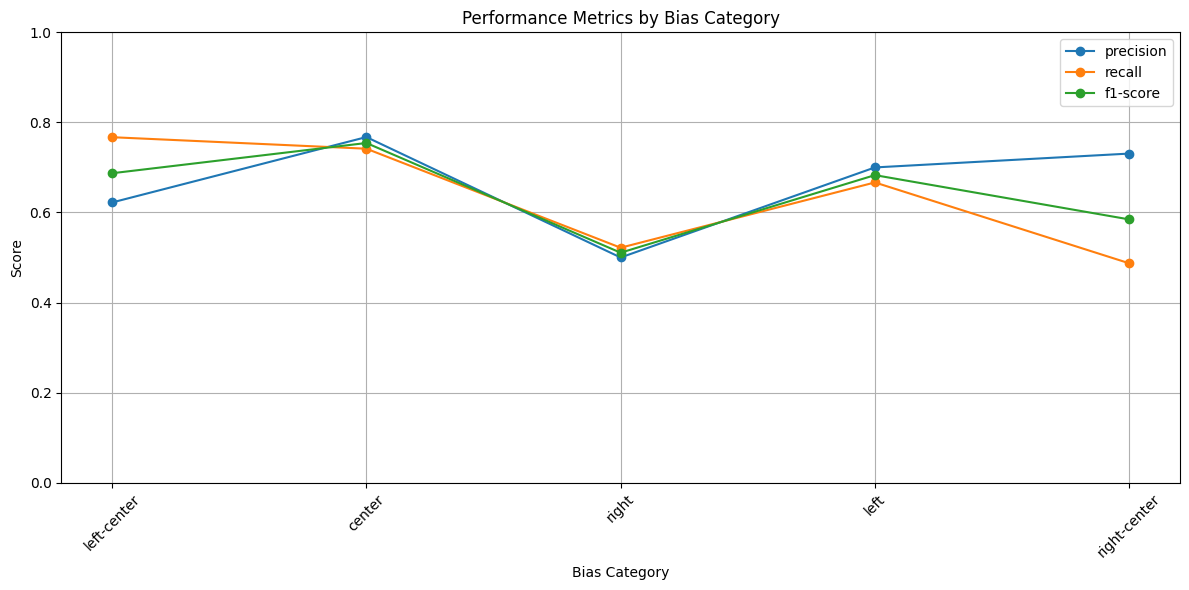

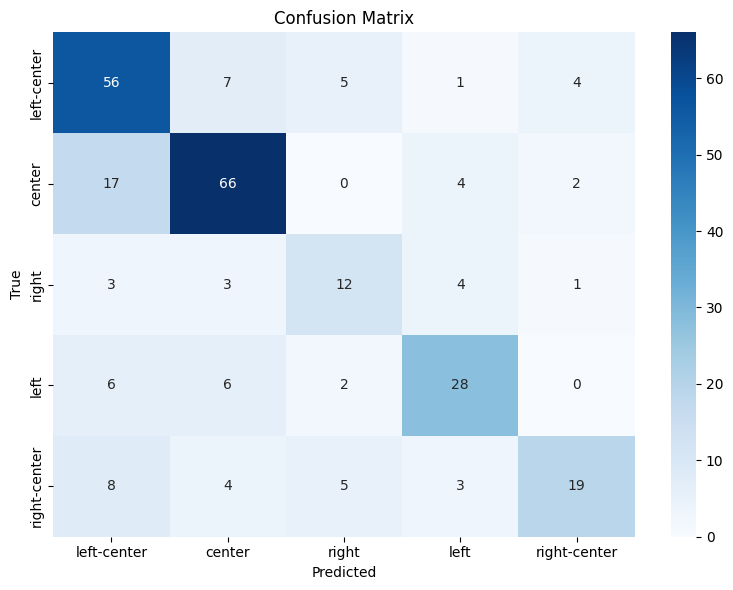


Test Evaluation Stats:
Accuracy: 0.6428571428571429
High Confidence Predictions: 266
Low Confidence Predictions: 0


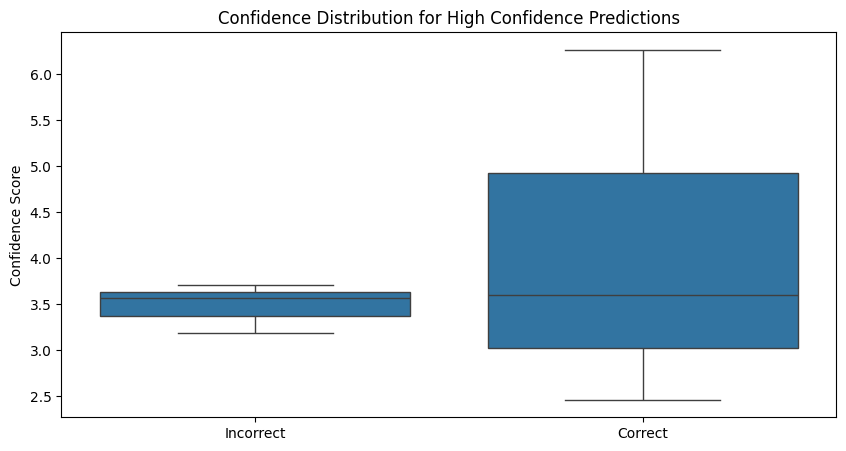

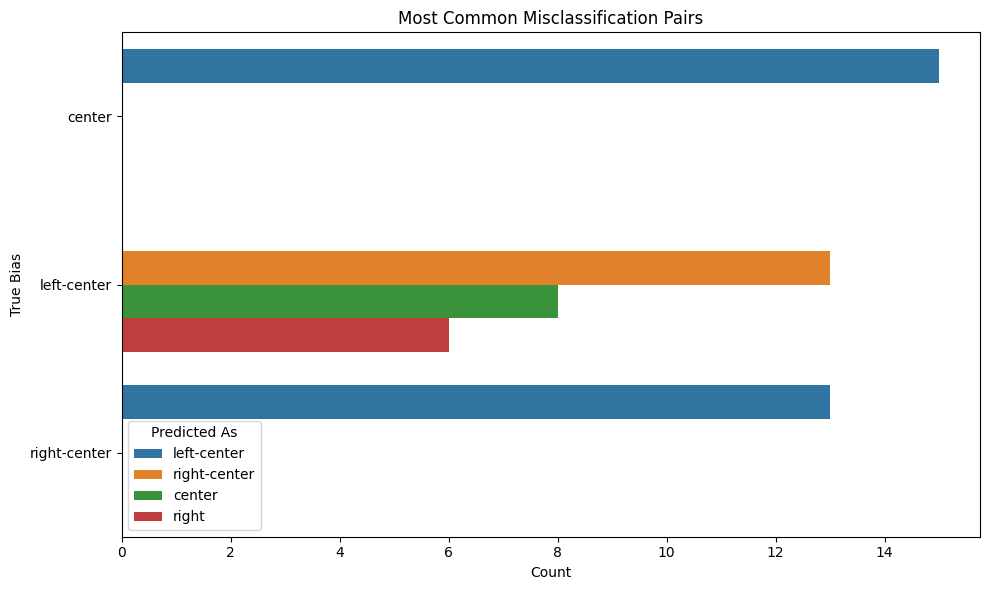

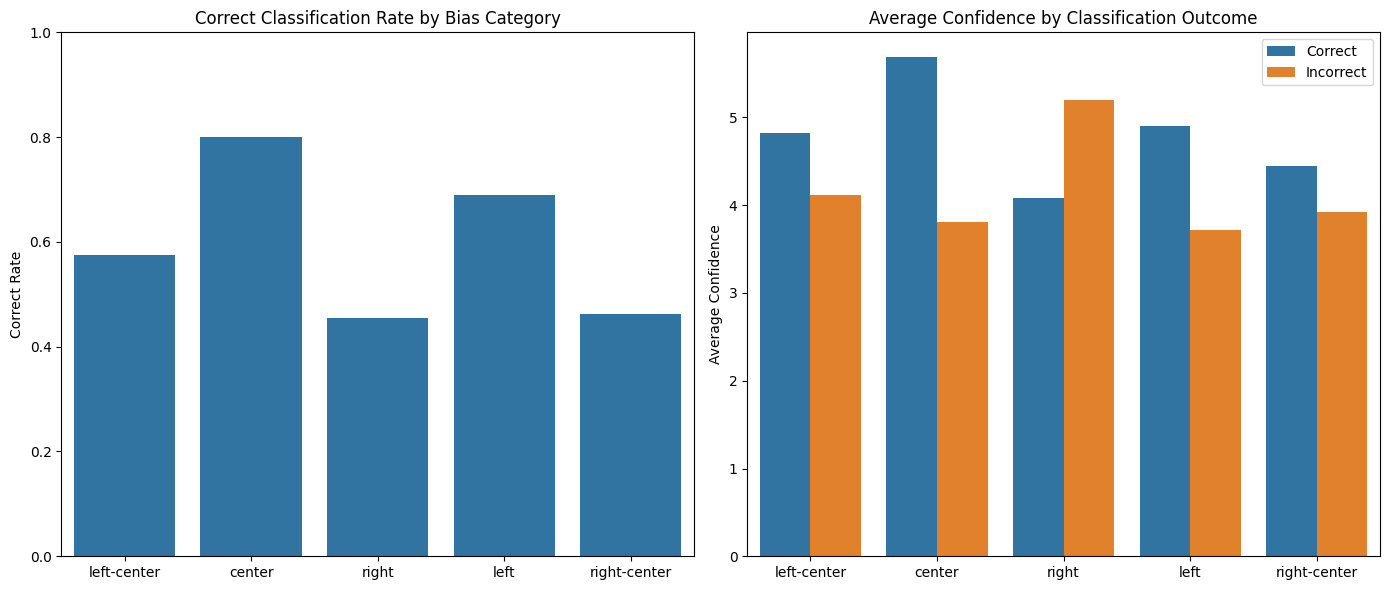

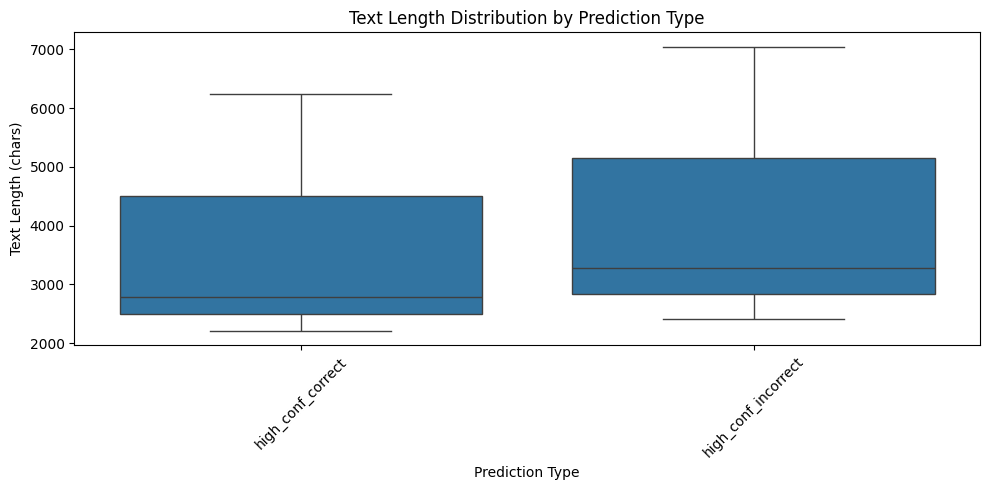

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Load the JSON data
with open('experiments/news_bias_demo/results.json') as f:
    data = json.load(f)

# 1. Overall Performance Metrics
print("Overall Accuracy:", data['training_results']['accuracy'])
print("F1 Score:", data['training_results']['f1_score'])

# 2. Classification Report Visualization
classification_report = data['training_results']['classification_report']
bias_categories = [k for k in classification_report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
metrics = ['precision', 'recall', 'f1-score']

df_report = pd.DataFrame(columns=['Category'] + metrics)
for cat in bias_categories:
    row = [cat] + [classification_report[cat][m] for m in metrics]
    df_report.loc[len(df_report)] = row

# Plot metrics per category
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df_report['Category'], df_report[metric], marker='o', label=metric)
plt.title('Performance Metrics by Bias Category')
plt.xlabel('Bias Category')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Confusion Matrix Visualization
conf_matrix = data['training_results']['confusion_matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=bias_categories, yticklabels=bias_categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 4. Test Evaluation Analysis
test_stats = data['test_evaluation']['general_stats']
print("\nTest Evaluation Stats:")
print(f"Accuracy: {test_stats['accuracy']}")
print(f"High Confidence Predictions: {test_stats['high_conf_predictions']}")
print(f"Low Confidence Predictions: {test_stats['low_conf_predictions']}")

# 5. High Confidence Examples Analysis
high_conf = data['test_evaluation']['examples']['high_conf_correct'] + \
            data['test_evaluation']['examples']['high_conf_incorrect']

confidences = [ex['confidence'] for ex in high_conf]
correct = [1 if ex in data['test_evaluation']['examples']['high_conf_correct'] else 0 for ex in high_conf]

plt.figure(figsize=(10, 5))
sns.boxplot(x=correct, y=confidences)
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.title('Confidence Distribution for High Confidence Predictions')
plt.ylabel('Confidence Score')
plt.show()

# 6. Misclassification Patterns
misclass_pairs = data['qualitative_analysis']['misclassification_pairs']
misclass_df = pd.DataFrame(misclass_pairs)

plt.figure(figsize=(10, 6))
sns.barplot(data=misclass_df, x='count', y='true_bias', hue='predicted_bias')
plt.title('Most Common Misclassification Pairs')
plt.xlabel('Count')
plt.ylabel('True Bias')
plt.legend(title='Predicted As')
plt.tight_layout()
plt.show()

# 7. Bias Patterns Analysis
bias_patterns = data['qualitative_analysis']['bias_patterns']
categories = list(bias_patterns.keys())
correct_rates = [bias_patterns[cat]['correct_rate'] for cat in categories]
avg_conf_correct = [bias_patterns[cat]['avg_confidence_correct'] for cat in categories]
avg_conf_incorrect = [bias_patterns[cat]['avg_confidence_incorrect'] for cat in categories]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=categories, y=correct_rates, ax=ax1)
ax1.set_title('Correct Classification Rate by Bias Category')
ax1.set_ylabel('Correct Rate')
ax1.set_ylim(0, 1)

sns.barplot(x=categories*2, y=avg_conf_correct+avg_conf_incorrect,
            hue=['Correct']*len(categories)+['Incorrect']*len(categories), ax=ax2)
ax2.set_title('Average Confidence by Classification Outcome')
ax2.set_ylabel('Average Confidence')
plt.tight_layout()
plt.show()

# 8. Example Text Length Analysis (additional insight)
text_lengths = []
for ex_type in ['high_conf_correct', 'high_conf_incorrect', 'low_conf_correct', 'low_conf_incorrect']:
    for ex in data['test_evaluation']['examples'].get(ex_type, []):
        text_lengths.append({
            'type': ex_type,
            'length': len(ex['Main Text'])
        })

df_lengths = pd.DataFrame(text_lengths)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_lengths, x='type', y='length')
plt.title('Text Length Distribution by Prediction Type')
plt.xlabel('Prediction Type')
plt.ylabel('Text Length (chars)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
import pandas as pd
import re
import string

def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)                     # Remove HTML
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()              # Remove extra whitespace
    return text

# Apply preprocessing
df['processed'] = df['Main Text'].apply(preprocess)

# Combine all text and count words
all_text = ' '.join(df['processed'].tolist())
word_counts = Counter(all_text.split())

# Get top 100
top_100 = word_counts.most_common(200)

# Print
print("\nTop 100 most common words in 'Main Text':")
for word, count in top_100:
    print(f"{word}: {count}")



Top 100 most common words in 'Main Text':
the: 60914
to: 30533
and: 27400
of: 25151
a: 24588
in: 22340
that: 12518
for: 11111
on: 10877
is: 9223
with: 7844
was: 6802
said: 6432
as: 6430
at: 6103
it: 5950
he: 5663
from: 5308
his: 5011
be: 4862
have: 4696
are: 4625
this: 4624
by: 4610
has: 4585
an: 4202
not: 3759
but: 3717
news: 3536
i: 3530
they: 3432
who: 3340
trump: 3257
will: 3229
we: 3016
their: 3002
you: 2926
—: 2844
more: 2826
or: 2825
about: 2731
were: 2669
her: 2636
after: 2540
she: 2526
been: 2509
us: 2502
had: 2359
its: 2332
new: 2325
also: 2312
which: 2240
one: 2224
would: 2178
all: 2150
up: 2038
out: 2009
our: 1984
people: 1932
when: 1850
president: 1841
if: 1804
what: 1723
so: 1681
can: 1640
like: 1601
over: 1573
first: 1566
just: 1531
than: 1517
other: 1512
no: 1507
time: 1452
into: 1449
last: 1429
could: 1426
some: 1372
two: 1366
there: 1356
advertisement: 1352
your: 1326
years: 1280
according: 1240
during: 1231
do: 1221
while: 1213
how: 1200
them: 1188
get: 1176
my: 117



---



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'news_bias_demo_2': {'model_type': 'bert', 'training_results': {'accuracy': 0.7481203007518797, 'f1_score': 0.7371118749092318, 'classification_report': {'slightly_biased': {'precision': 0.7478260869565218, 'recall': 0.7678571428571429, 'f1-score': 0.7577092511013216, 'support': 112.0}, 'not-biased': {'precision': 0.8372093023255814, 'recall': 0.8089887640449438, 'f1-score': 0.8228571428571428, 'support': 89.0}, 'biased': {'precision': 0.6307692307692307, 'recall': 0.6307692307692307, 'f1-score': 0.6307692307692307, 'support': 65.0}, 'accuracy': 0.7481203007518797, 'macro avg': {'precision': 0.7386015400171114, 'recall': 0.7358717125571058, 'f1-score': 0.7371118749092318, 'support': 266.0}, 'weighted avg': {'precision': 0.7491283821282225, 'recall': 0.7481203007518797, 'f1-score': 0.7484876760813298, 'support': 266.0}}, 'confusion_matrix': [[86, 9, 17], [10, 72, 7], [19, 5, 41]]}, 'test_evaluation': {'general_stats': {'accuracy': np.float64(0.7631578947368421), 'high_conf_predictions'

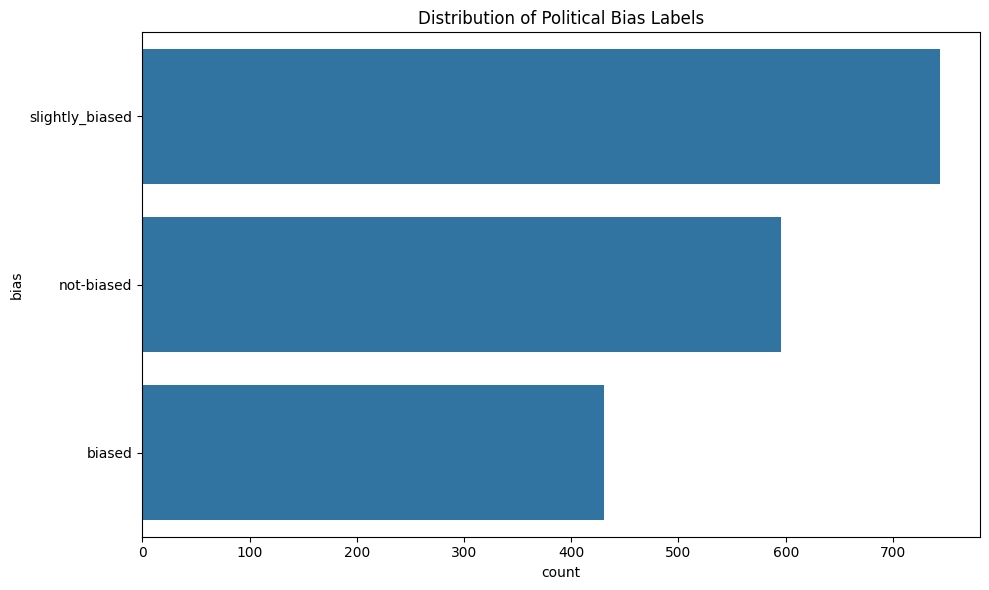

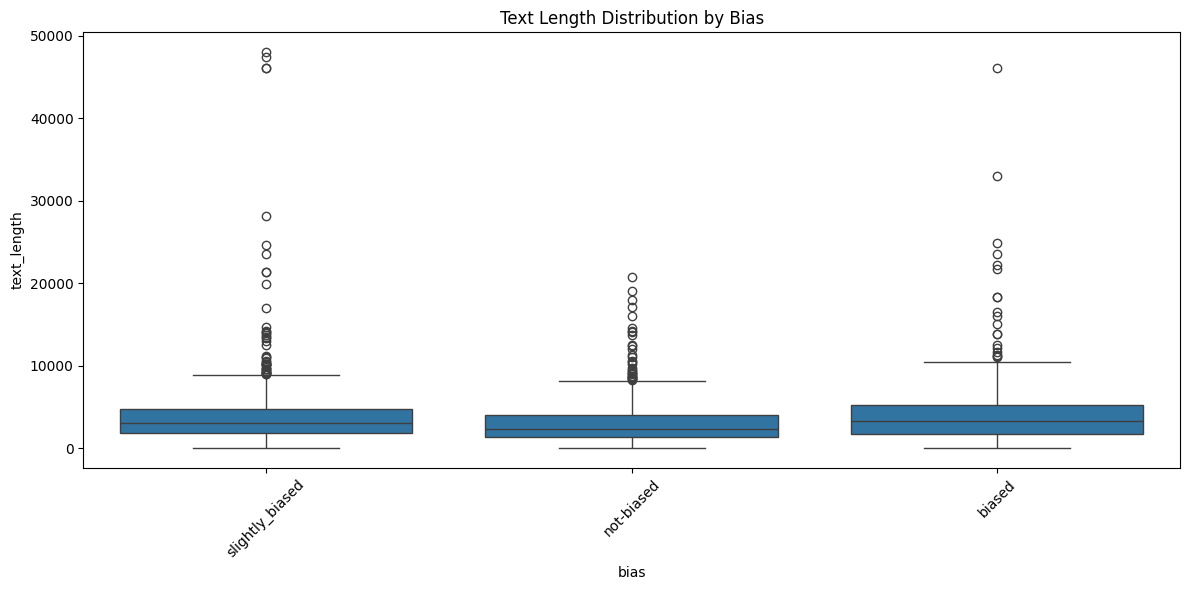

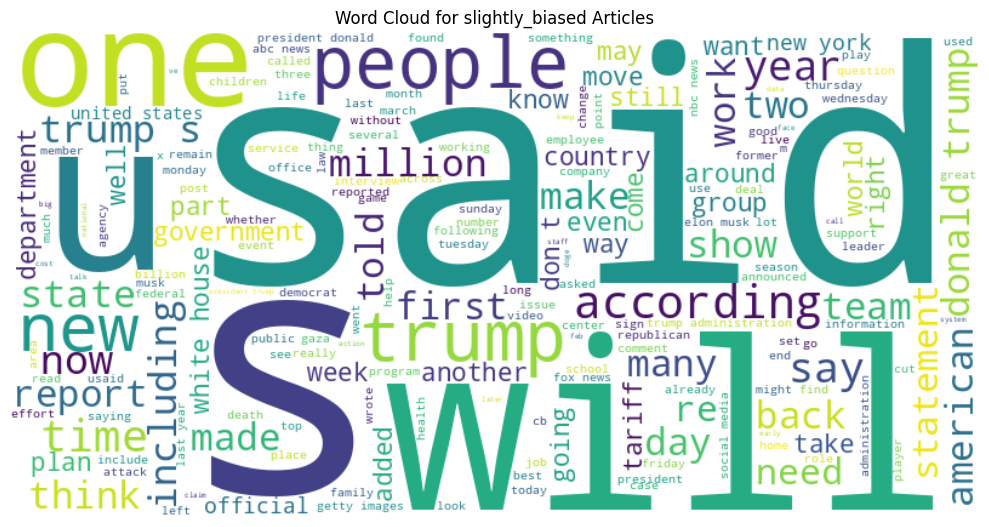

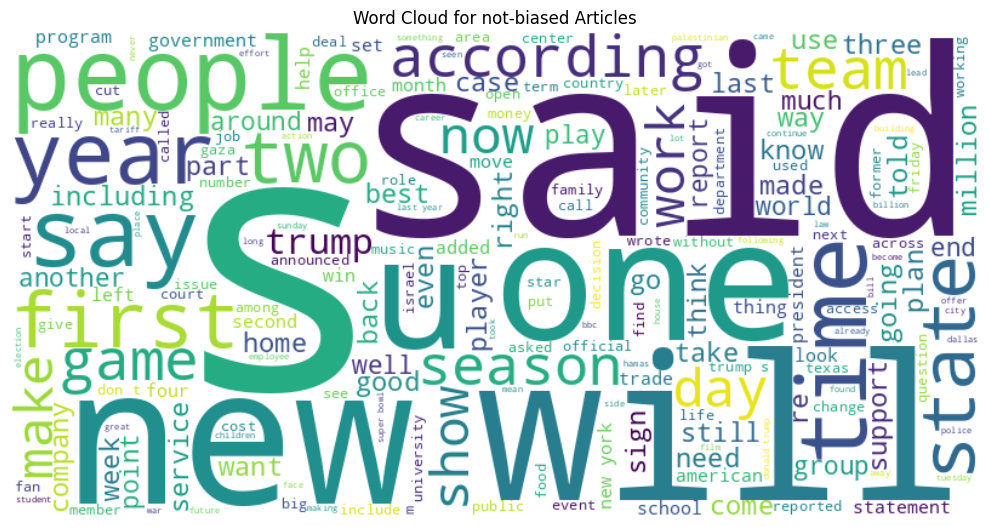

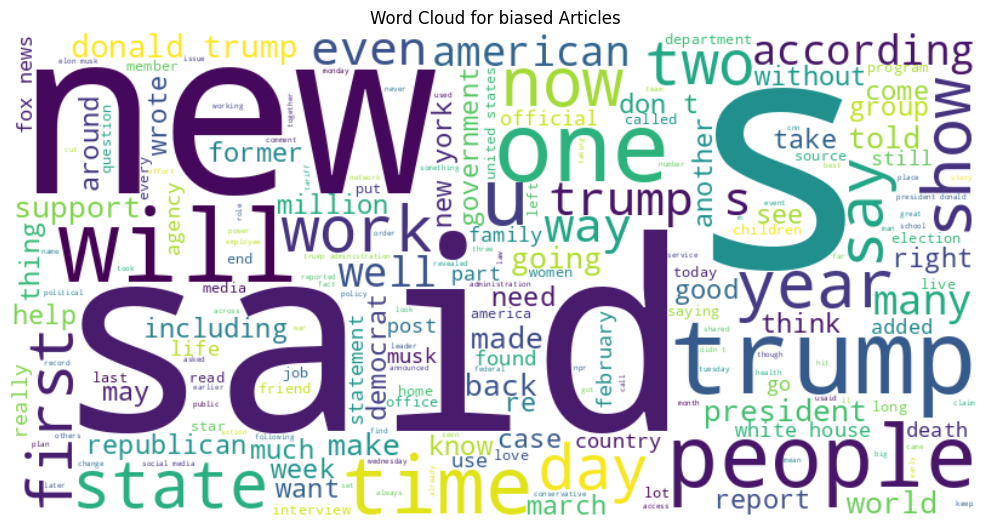

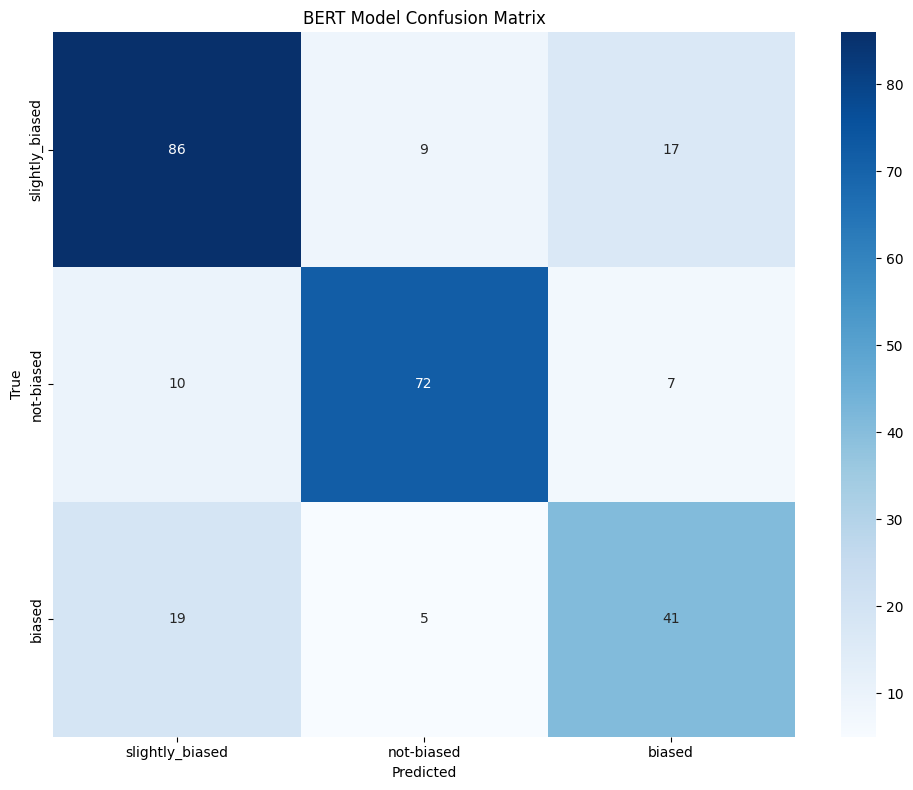

In [ ]:
"""
News Bias Classification Pipeline

This script implements a complete pipeline for classifying news articles based on their political bias.
Following the structured approach from the project outline with stages and checkpoints.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import warnings
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import random
import os
import logging
import json
from datetime import datetime

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("news_bias_classifier.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)




class NewsBiasClassifier:
    """
    End-to-end pipeline for classifying news articles based on political bias.
    """

    def __init__(self, config=None):
        """
        Initialize the classifier with configuration settings.

        Args:
            config (dict): Configuration parameters for the pipeline
        """
        # Default configuration
        self.default_config = {
            'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
            'random_seed': RANDOM_SEED,
            'model_type': 'bert',
            'bert_model': 'distilbert-base-uncased',  # Still a good fast baseline
            'max_length': 256,  # 512 is often excessive unless your articles are very long
            'batch_size': 8,                  # Best: 8
            'learning_rate': 4.5431e-05,       # Best: ~4.54e-5
            'weight_decay': 0.0701,            # Best: 0.0701
            'warmup_steps': 300,               # Best: 300
            'epochs': 10,
            'weight_decay': 0.01,  # Regularization to reduce overfitting
            'class_weights': True,

            'tfidf_params': {
                'max_features': 10000,
                'min_df': 5,
                'max_df': 0.8,
                'ngram_range': (1, 2)
            },
            'logreg_params': {
                'C': 1.0,
                'max_iter': 1000,
                'class_weight': 'balanced'
            },
            'experiment_name': f"news_bias_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        }


        # Update with user config if provided
        self.config = self.default_config.copy()
        if config:
            self.config.update(config)

        # Initialize pipeline components
        self.model = None
        self.vectorizer = None
        self.label_encoder = None
        self.experiment_results = {}

        logger.info(f"Initialized NewsBiasClassifier with config: {self.config}")

    def preprocess_text(self, text):
        """
        Clean and preprocess text data.

        Args:
            text (str): Raw text

        Returns:
            str: Cleaned text
        """
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        text = re.sub(r'Advertisement', '', text)
        text = re.sub(r'advertisement', '', text)
        text = re.sub(r'More information', '', text)
        text = re.sub(r'more information', '', text)

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def load_and_prepare_data(self, df):
        """
        Load data, perform EDA, and prepare datasets for training.

        Args:
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Dictionary containing train, validation, and test datasets
        """
        logger.info("Starting data preparation...")

        # Make a copy to avoid modifying the original dataframe
        data = df.copy()

        # Check for missing values
        missing_values = data.isnull().sum()
        logger.info(f"Missing values in dataset:\n{missing_values}")

        # Filter out rows with missing Main Text
        original_size = len(data)
        data = data.dropna(subset=['Main Text'])
        logger.info(f"Dropped {original_size - len(data)} rows with missing Main Text")

        # Convert bias labels to categories if needed
        if 'bias' in data.columns:
            # Check bias distribution
            bias_distribution = data['bias'].value_counts()
            logger.info(f"Bias label distribution:\n{bias_distribution}")

            # Create numerical encoding for bias labels
            unique_biases = data['bias'].unique()
            self.bias_categories = {bias: idx for idx, bias in enumerate(unique_biases)}
            data['bias_encoded'] = data['bias'].map(self.bias_categories)

            # Keep track of the mapping for interpretation
            self.idx_to_bias = {idx: bias for bias, idx in self.bias_categories.items()}

            logger.info(f"Encoded bias categories: {self.bias_categories}")

        # Preprocess text
        logger.info("Preprocessing text data...")
        data['processed_text'] = data['Main Text'].apply(self.preprocess_text)

        # Check text length distribution
        data['text_length'] = data['processed_text'].apply(len)

        # Split data
        train_val, test = train_test_split(
            data,
            test_size=self.config['data_split']['test'],
            random_state=self.config['random_seed'],
            stratify=data['bias_encoded'] if 'bias_encoded' in data.columns else None
        )

        train, val = train_test_split(
            train_val,
            test_size=self.config['data_split']['val'] / (self.config['data_split']['train'] + self.config['data_split']['val']),
            random_state=self.config['random_seed'],
            stratify=train_val['bias_encoded'] if 'bias_encoded' in train_val.columns else None
        )

        logger.info(f"Data split sizes - Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

        return {
            'train': train,
            'val': val,
            'test': test,
            'full_data': data
        }

    def perform_eda(self, data):
        """
        Perform Exploratory Data Analysis on the dataset.

        Args:
            data (dict): Dictionary containing data splits

        Returns:
            dict: EDA results and visualizations
        """
        logger.info("Performing Exploratory Data Analysis...")

        full_data = data['full_data']

        eda_results = {
            'dataset_info': {
                'total_samples': len(full_data),
                'bias_distribution': full_data['bias'].value_counts().to_dict() if 'bias' in full_data.columns else None,
                'text_length_stats': {
                    'mean': full_data['text_length'].mean(),
                    'median': full_data['text_length'].median(),
                    'min': full_data['text_length'].min(),
                    'max': full_data['text_length'].max()
                }
            }
        }

        logger.info(f"Dataset info:\n{json.dumps(eda_results['dataset_info'], indent=2)}")

        # Generate visualizations
        if 'bias' in full_data.columns:
            # Plot bias distribution
            plt.figure(figsize=(10, 6))
            sns.countplot(y='bias', data=full_data)
            plt.title('Distribution of Political Bias Labels')
            plt.tight_layout()
            plt.savefig('bias_distribution.png')

            # Plot text length by bias
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='bias', y='text_length', data=full_data)
            plt.title('Text Length Distribution by Bias')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('text_length_by_bias.png')

            # Generate word clouds by bias category
            for bias in full_data['bias'].unique():
                bias_text = ' '.join(full_data[full_data['bias'] == bias]['processed_text'])
                if bias_text.strip():  # Ensure there's text to process
                    wc = WordCloud(width=800, height=400, background_color='white', max_words=200)
                    wc.generate(bias_text)

                    plt.figure(figsize=(10, 6))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud for {bias} Articles')
                    plt.tight_layout()
                    plt.savefig(f'wordcloud_{bias.replace(" ", "_")}.png')

        logger.info("EDA completed and visualizations saved")
        return eda_results

    def build_tfidf_logreg_model(self):
        """
        Build a TF-IDF + Logistic Regression pipeline.

        Returns:
            sklearn.pipeline.Pipeline: Model pipeline
        """
        logger.info("Building TF-IDF + Logistic Regression model...")

        # Create TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            max_features=self.config['tfidf_params']['max_features'],
            min_df=self.config['tfidf_params']['min_df'],
            max_df=self.config['tfidf_params']['max_df'],
            ngram_range=self.config['tfidf_params']['ngram_range'],
            stop_words='english'
        )

        # Create logistic regression model
        logreg = LogisticRegression(
            C=self.config['logreg_params']['C'],
            max_iter=self.config['logreg_params']['max_iter'],
            class_weight=self.config['logreg_params']['class_weight'] if self.config['class_weights'] else None,
            random_state=self.config['random_seed']
        )

        # Create pipeline
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('logreg', logreg)
        ])

        return pipeline

    def build_bert_model(self, num_labels):
        """
        Build a BERT-based model for text classification.

        Args:
            num_labels (int): Number of target classes

        Returns:
            tuple: (tokenizer, model) for the BERT-based classifier
        """
        logger.info(f"Building BERT model ({self.config['bert_model']})...")

        # Load pre-trained tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])
        model = AutoModelForSequenceClassification.from_pretrained(
            self.config['bert_model'],
            num_labels=num_labels
        )

        return tokenizer, model

    def train_tfidf_logreg(self, train_data, val_data):
        """
        Train and evaluate the TF-IDF + Logistic Regression model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, evaluation_results)
        """
        logger.info("Training TF-IDF + Logistic Regression model...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Build and train the model
        model = self.build_tfidf_logreg_model()
        model.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        classification_rep = classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()), output_dict=True)
        conf_matrix = confusion_matrix(y_val, y_pred)

        # Log results
        logger.info(f"Validation Accuracy: {accuracy:.4f}")
        logger.info(f"Validation F1 Score (macro): {f1:.4f}")
        logger.info(f"Classification Report:\n{classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()))}")

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('tfidf_logreg_confusion_matrix.png')

        # Return the trained model and evaluation results
        results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': classification_rep,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, results

    def train_bert(self, train_data, val_data):
        """
        Train and evaluate the BERT-based model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, tokenizer, evaluation_results)
        """
        logger.info("Training BERT model...")

        # Prepare the tokenizer and model
        num_labels = len(self.bias_categories)
        tokenizer, model = self.build_bert_model(num_labels)

        # Prepare the datasets
        class NewsDataset(torch.utils.data.Dataset):
            def __init__(self, texts, labels, tokenizer, max_length):
                self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        # Create datasets
        train_dataset = NewsDataset(
            train_data['processed_text'].tolist(),
            train_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        val_dataset = NewsDataset(
            val_data['processed_text'].tolist(),
            val_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        # Compute class weights for handling imbalance
        if self.config['class_weights']:
            class_counts = train_data['bias_encoded'].value_counts().sort_index()
            total_samples = len(train_data)
            class_weights = torch.tensor(
                [total_samples / (len(class_counts) * count) for count in class_counts],
                dtype=torch.float
            )
            logger.info(f"Class weights: {class_weights}")
        else:
            class_weights = None

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/{self.config['experiment_name']}",
            num_train_epochs=self.config['epochs'],
            per_device_train_batch_size=self.config['batch_size'],
            per_device_eval_batch_size=self.config['batch_size'],
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            learning_rate=self.config['learning_rate'],
        )

        # Define compute metrics function
        def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            f1 = f1_score(labels, preds, average='macro')
            acc = accuracy_score(labels, preds)
            return {'accuracy': acc, 'f1': f1}

        # Create trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        eval_results = trainer.evaluate()
        logger.info(f"Evaluation results: {eval_results}")

        # Make predictions for confusion matrix
        val_predictions = trainer.predict(val_dataset)
        y_pred = np.argmax(val_predictions.predictions, axis=1)
        y_true = val_data['bias_encoded'].values

        # Calculate detailed metrics
        class_report = classification_report(
            y_true, y_pred,
            target_names=list(self.bias_categories.keys()),
            output_dict=True
        )
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('BERT Model Confusion Matrix')
        plt.tight_layout()
        plt.savefig('bert_confusion_matrix.png')

        # Return results
        results = {
            'accuracy': eval_results['eval_accuracy'],
            'f1_score': eval_results['eval_f1'],
            'classification_report': class_report,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, tokenizer, results

    def hyperparameter_tuning(self, train_data, val_data):
        """
        Perform hyperparameter tuning for the TF-IDF + LogReg model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            dict: Best parameters and results
        """
        logger.info("Starting hyperparameter tuning for TF-IDF + LogReg...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Define parameter grid
        param_grid = {
            'tfidf__max_features': [5000, 10000, 15000],
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'logreg__C': [0.1, 1.0, 10.0]
        }

        # Build base model
        model = self.build_tfidf_logreg_model()

        # Set up grid search with cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.config['random_seed'])
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=cv,
            scoring='f1_macro',
            verbose=1,
            n_jobs=-1
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        logger.info(f"Best CV score: {best_score:.4f}")
        logger.info(f"Best parameters: {best_params}")

        # Evaluate best model on validation set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)

        val_accuracy = accuracy_score(y_val, y_pred)
        val_f1 = f1_score(y_val, y_pred, average='macro')

        logger.info(f"Validation Accuracy with best model: {val_accuracy:.4f}")
        logger.info(f"Validation F1 Score with best model: {val_f1:.4f}")

        # Update config with best parameters
        for param, value in best_params.items():
            component, parameter = param.split('__')
            if component == 'tfidf':
                self.config['tfidf_params'][parameter] = value
            elif component == 'logreg':
                self.config['logreg_params'][parameter] = value

        tuning_results = {
            'best_params': best_params,
            'best_cv_score': best_score,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        }

        return best_model, tuning_results

    def evaluate_model(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
        """
        Evaluate the trained model on the test set.

        Args:
            model: Trained model
            test_data (pandas.DataFrame): Test dataset
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            dict: Evaluation metrics
        """
        logger.info(f"Evaluating {model_type} model on test data...")

        X_test = test_data['processed_text']
        y_test = test_data['bias_encoded']

        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)

        elif model_type == 'bert':
            # For BERT model

            # Create dataset
            class NewsDataset(torch.utils.data.Dataset):
                def __init__(self, texts, labels, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                    self.labels = labels

                def __getitem__(self, idx):
                    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                    item['labels'] = torch.tensor(self.labels[idx])
                    return item

                def __len__(self):
                    return len(self.labels)

            test_dataset = NewsDataset(
                X_test.tolist(),
                y_test.tolist(),
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            test_predictions = trainer.predict(test_dataset)

            y_prob = test_predictions.predictions
            y_pred = np.argmax(y_prob, axis=1)

        # Create combined dataframe with predictions
        analysis_df = test_data.copy()
        analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
        analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
        analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

        # Find confident correct and incorrect predictions
        if model_type == 'tfidf_logreg':
            analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
        else:
            analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

        high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
        low_conf_predictions = analysis_df[analysis_df['confidence'] < 0.6]

        # Analyze potentially neutral articles
        neutral_predictions = []
        if model_type == 'tfidf_logreg':
            # If max probability is low across all classes, the article might be neutral
            for i, probs in enumerate(y_prob):
                if np.max(probs) < 0.4:  # Low confidence threshold
                    neutral_predictions.append({
                        'index': i,
                        'text': test_data.iloc[i]['Main Text'][:300] + '...',
                        'predicted_bias': self.idx_to_bias[y_pred[i]],
                        'true_bias': self.idx_to_bias[y_test.iloc[i]],
                        'confidence': np.max(probs),
                        'all_probs': {self.idx_to_bias[j]: prob for j, prob in enumerate(probs)}
                    })

        # Return qualitative analysis results
        results = {
            'general_stats': {
                'accuracy': (analysis_df['correct'].sum() / len(analysis_df)),
                'high_conf_predictions': len(analysis_df[analysis_df['confidence'] > 0.8]),
                'low_conf_predictions': len(analysis_df[analysis_df['confidence'] < 0.6]),
            },
            'examples': {
                'high_conf_correct': high_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'high_conf_incorrect': high_conf_incorrect.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'low_conf_correct': low_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'potential_neutral': neutral_predictions[:3] if neutral_predictions else []
            }
        }

        # Log summary of findings
        logger.info("Qualitative Analysis Summary:")
        logger.info(f"  - {results['general_stats']['high_conf_predictions']} high confidence predictions (>0.8)")
        logger.info(f"  - {results['general_stats']['low_conf_predictions']} low confidence predictions (<0.6)")
        logger.info(f"  - {len(high_conf_incorrect)} predictions that are highly confident but wrong")
        logger.info(f"  - Found {len(neutral_predictions)} potentially neutral articles")

        return results

    def feature_importance(self, model, model_type='tfidf_logreg'):
        """
        Extract and analyze feature importance from the model

        Args:
            model: Trained model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            dict: Feature importance analysis
        """
        if model_type != 'tfidf_logreg':
            logger.info("Feature importance analysis is only available for TF-IDF + LogReg models")
            return None

        logger.info("Analyzing feature importance...")

        # Extract the vectorizer and classifier from the pipeline
        vectorizer = model.named_steps['tfidf']
        classifier = model.named_steps['logreg']

        # Get feature names from the vectorizer
        feature_names = vectorizer.get_feature_names_out()

        # For each class, get the most important features
        important_features = {}

        for class_id, class_name in self.idx_to_bias.items():
            # Get coefficients for this class
            if classifier.coef_.shape[0] > 1:  # multi-class case
                coefficients = classifier.coef_[class_id]
            else:  # binary case
                coefficients = classifier.coef_[0] * (1 if class_id == 1 else -1)

            # Get top positive and negative features
            top_positive_indices = np.argsort(coefficients)[-20:]
            top_negative_indices = np.argsort(coefficients)[:20]

            top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
            top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

            important_features[class_name] = {
                'top_positive': top_positive,
                'top_negative': top_negative
            }

            # Log important features
            logger.info(f"Most important features for class '{class_name}':")
            logger.info("  Top positive features:")
            for feature, coef in top_positive[::-1]:
                logger.info(f"    {feature}: {coef:.4f}")

            logger.info("  Top negative features:")
            for feature, coef in top_negative:
                logger.info(f"    {feature}: {coef:.4f}")

        # Visualize top features for each class
        for class_name, features in important_features.items():
            plt.figure(figsize=(12, 8))

            # Plot positive features
            pos_features = features['top_positive']
            pos_features.sort(key=lambda x: x[1])
            plt.barh(
                [f[0] for f in pos_features],
                [f[1] for f in pos_features],
                color='green',
                alpha=0.7
            )

            plt.title(f'Top Features for "{class_name}" Class')
            plt.xlabel('Coefficient Value')
            plt.tight_layout()
            plt.savefig(f'feature_importance_{class_name.replace(" ", "_")}.png')

        return important_features

    def run_experiment(self, experiment_config, df):
        """
        Run a complete experiment with the given configuration.

        Args:
            experiment_config (dict): Configuration for the experiment
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Experiment results
        """
        # Update configuration
        self.config.update(experiment_config)
        exp_name = self.config['experiment_name']
        logger.info(f"Starting experiment: {exp_name}")

        # Step 1: Load and prepare data
        data_splits = self.load_and_prepare_data(df)

        # Step 2: Perform EDA
        eda_results = self.perform_eda(data_splits)

        # Step 3: Train model
        if self.config['model_type'] == 'tfidf_logreg':
            # [Existing TF-IDF + LogReg code...]
            pass

        elif self.config['model_type'] == 'bert':
            # Optional: Hyperparameter tuning for BERT
            if experiment_config.get('perform_tuning', False):
                model, tokenizer, tuning_results = self.hyperparameter_tuning_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'tuning_results': tuning_results
                }
            else:
                # Regular BERT training
                model, tokenizer, train_results = self.train_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'training_results': train_results
                }

            # Evaluate on test set
            test_results = self.evaluate_model(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['test_evaluation'] = test_results

            # Qualitative analysis
            qual_results = self.qualitative_analysis(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['qualitative_analysis'] = qual_results

        # Save experiment results
        self.experiment_results[exp_name] = results

        # Save model and results
        self._save_experiment(exp_name, model, results)

        logger.info(f"Experiment {exp_name} completed")
        return results

    def _save_experiment(self, exp_name, model, results):
        """
        Save experiment model and results to disk.

        Args:
            exp_name (str): Name of the experiment
            model: Trained model
            results (dict): Experiment results
        """
        # Create directory
        os.makedirs(f"./experiments/{exp_name}", exist_ok=True)

        # Save results as JSON
        with open(f"./experiments/{exp_name}/results.json", 'w') as f:
            json.dump(results, f, indent=2, default=lambda x: str(x))

        # Save config
        with open(f"./experiments/{exp_name}/config.json", 'w') as f:
            json.dump(self.config, f, indent=2)

        # Save model
        if results['model_type'] == 'tfidf_logreg':
            import joblib
            joblib.dump(model, f"./experiments/{exp_name}/model.joblib")
        else:
            # For BERT, save the model using transformers
            model.save_pretrained(f"./experiments/{exp_name}/model")

        logger.info(f"Saved experiment {exp_name} to disk")

    def predict(self, texts, model=None, model_type=None, tokenizer=None):
        """
        Make predictions on new texts.

        Args:
            texts (list): List of text strings to predict
            model: Model to use for prediction (if None, use the last trained model)
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            list: Predicted bias labels and probabilities
        """
        # Use current model and type if not provided
        if model is None:
            model = self.model

        if model_type is None:
            model_type = self.config['model_type']

        # Ensure model is loaded
        if model is None:
            raise ValueError("No model available for prediction")

        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]

        # Make predictions
        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_prob = model.predict_proba(processed_texts)
            y_pred = model.predict(processed_texts)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: prob for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': np.max(y_prob[i])
                })

        elif model_type == 'bert':
            # For BERT model
            if tokenizer is None:
                raise ValueError("Tokenizer must be provided for BERT predictions")

            # Create dataset
            class PredictionDataset(torch.utils.data.Dataset):
                def __init__(self, texts, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

                def __getitem__(self, idx):
                    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

                def __len__(self):
                    return len(self.encodings['input_ids'])

            # Create dataset and make predictions
            pred_dataset = PredictionDataset(
                processed_texts,
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            predictions_output = trainer.predict(pred_dataset)

            y_prob = predictions_output.predictions
            y_pred = np.argmax(y_prob, axis=1)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: float(prob) for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': float(np.max(y_prob[i]))
                })

        return predictions

    def deploy_model(self, model_path, model_type='tfidf_logreg'):
        """
        Load a saved model for deployment.

        Args:
            model_path (str): Path to the saved model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            tuple: (model, tokenizer) - tokenizer is None for tfidf_logreg
        """
        logger.info(f"Loading {model_type} model from {model_path}")

        # Load config
        with open(os.path.join(os.path.dirname(model_path), 'config.json'), 'r') as f:
            self.config = json.load(f)

        # Load model
        if model_type == 'tfidf_logreg':
            import joblib
            model = joblib.load(model_path)
            tokenizer = None

        elif model_type == 'bert':
            # For BERT, load the model and tokenizer
            model = AutoModelForSequenceClassification.from_pretrained(model_path)
            tokenizer = AutoTokenizer.from_pretrained(model_path)

        self.model = model
        self.model_type = model_type

        logger.info(f"Model loaded successfully")
        return model, tokenizer

    def hyperparameter_tuning_bert(self, train_data, val_data):
      """
      Perform hyperparameter tuning for the BERT model using Optuna or similar.

      Args:
          train_data (pandas.DataFrame): Training data
          val_data (pandas.DataFrame): Validation data

      Returns:
          tuple: (best_model, best_tokenizer, tuning_results)
      """
      logger.info("Starting hyperparameter tuning for BERT model...")

      import optuna
      from optuna.integration import PyTorchLightningPruningCallback

      # Prepare datasets
      num_labels = len(self.bias_categories)
      tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])

      class NewsDataset(torch.utils.data.Dataset):
          def __init__(self, texts, labels, tokenizer, max_length):
              self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
              self.labels = labels

          def __getitem__(self, idx):
              item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
              item['labels'] = torch.tensor(self.labels[idx])
              return item

          def __len__(self):
              return len(self.labels)

      train_dataset = NewsDataset(
          train_data['processed_text'].tolist(),
          train_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      val_dataset = NewsDataset(
          val_data['processed_text'].tolist(),
          val_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      def objective(trial):
          # Define hyperparameters to tune
          learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
          batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
          weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
          warmup_steps = trial.suggest_int("warmup_steps", 100, 1000, step=100)

          # Load model with current hyperparameters
          model = AutoModelForSequenceClassification.from_pretrained(
              self.config['bert_model'],
              num_labels=num_labels
          )

          # Training arguments
          training_args = TrainingArguments(
              output_dir=f"./results/{self.config['experiment_name']}/trial_{trial.number}",
              per_device_train_batch_size=batch_size,
              per_device_eval_batch_size=batch_size,
              learning_rate=learning_rate,
              weight_decay=weight_decay,
              warmup_steps=warmup_steps,
              num_train_epochs=10,  # Fewer epochs for faster tuning
              eval_strategy="epoch",
              save_strategy="epoch",
              logging_dir='./logs',
              logging_steps=10,
              load_best_model_at_end=True,
              metric_for_best_model="f1",
              greater_is_better=True,
          )

          # Define compute metrics function
          def compute_metrics(pred):
              labels = pred.label_ids
              preds = pred.predictions.argmax(-1)
              f1 = f1_score(labels, preds, average='macro')
              acc = accuracy_score(labels, preds)
              return {'accuracy': acc, 'f1': f1}

          # Create trainer
          trainer = Trainer(
              model=model,
              args=training_args,
              train_dataset=train_dataset,
              eval_dataset=val_dataset,
              compute_metrics=compute_metrics,
              data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
          )

          # Train and evaluate
          trainer.train()
          eval_results = trainer.evaluate()

          return eval_results['eval_f1']  # Optimize for F1 score

      # Create study and optimize
      study = optuna.create_study(direction="maximize")
      study.optimize(objective, n_trials=10)  # Number of trials

      # Get best hyperparameters
      best_params = study.best_params
      logger.info(f"Best hyperparameters: {best_params}")

      # Train final model with best hyperparameters
      model = AutoModelForSequenceClassification.from_pretrained(
          self.config['bert_model'],
          num_labels=num_labels
      )

      training_args = TrainingArguments(
          output_dir=f"./results/{self.config['experiment_name']}/best_model",
          per_device_train_batch_size=best_params['batch_size'],
          per_device_eval_batch_size=best_params['batch_size'],
          learning_rate=best_params['learning_rate'],
          weight_decay=best_params['weight_decay'],
          warmup_steps=best_params['warmup_steps'],
          num_train_epochs=self.config['epochs'],
          eval_strategy="epoch",
          save_strategy="epoch",
          logging_dir='./logs',
          logging_steps=10,
          load_best_model_at_end=True,
          metric_for_best_model="f1",
          greater_is_better=True,
      )

      # Define compute metrics function
      def compute_metrics(pred):
          labels = pred.label_ids
          preds = pred.predictions.argmax(-1)
          f1 = f1_score(labels, preds, average='macro')
          acc = accuracy_score(labels, preds)
          return {'accuracy': acc, 'f1': f1}

      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=val_dataset,
          compute_metrics=compute_metrics,
          data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
      )

      trainer.train()

      # Evaluate on validation set
      eval_results = trainer.evaluate()

      tuning_results = {
          'best_params': best_params,
          'best_score': study.best_value,
          'val_accuracy': eval_results['eval_accuracy'],
          'val_f1': eval_results['eval_f1'],
          'study': study.trials_dataframe().to_dict()
      }

      return model, tokenizer, tuning_results

    def qualitative_analysis(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
      """
      Perform qualitative analysis on model predictions.

      Args:
          model: Trained model
          test_data (pandas.DataFrame): Test dataset
          model_type (str): Type of model ('tfidf_logreg' or 'bert')
          tokenizer: BERT tokenizer (required if model_type is 'bert')

      Returns:
          dict: Qualitative analysis results
      """
      logger.info("Performing qualitative analysis of model predictions...")

      X_test = test_data['processed_text']
      y_test = test_data['bias_encoded']

      if model_type == 'tfidf_logreg':
          # For sklearn pipeline
          y_pred = model.predict(X_test)
          y_prob = model.predict_proba(X_test)

      elif model_type == 'bert':
          # For BERT model
          class NewsDataset(torch.utils.data.Dataset):
              def __init__(self, texts, labels, tokenizer, max_length):
                  self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                  self.labels = labels

              def __getitem__(self, idx):
                  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                  item['labels'] = torch.tensor(self.labels[idx])
                  return item

              def __len__(self):
                  return len(self.labels)

          test_dataset = NewsDataset(
              X_test.tolist(),
              y_test.tolist(),
              tokenizer,
              self.config['max_length']
          )

          # Set up trainer for prediction
          trainer = Trainer(model=model)
          test_predictions = trainer.predict(test_dataset)

          y_prob = test_predictions.predictions
          y_pred = np.argmax(y_prob, axis=1)

      # Create combined dataframe with predictions
      analysis_df = test_data.copy()
      analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
      analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
      analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

      # Set confidence scores
      if model_type == 'tfidf_logreg':
          analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
      else:
          analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

      # Find interesting examples for analysis
      high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
      low_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]

      # Analyze content patterns by categorizing articles
      category_patterns = {}
      for bias in self.idx_to_bias.values():
          # Find correctly classified articles for this bias
          correct_examples = analysis_df[(analysis_df['true_bias'] == bias) & (analysis_df['correct'])]
          # Find incorrectly classified articles for this bias
          incorrect_examples = analysis_df[(analysis_df['true_bias'] == bias) & (~analysis_df['correct'])]

          # Sample some examples
          category_patterns[bias] = {
              'correct_examples': correct_examples.sample(min(3, len(correct_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'incorrect_examples': incorrect_examples.sample(min(3, len(incorrect_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'correct_rate': len(correct_examples) / max(1, len(correct_examples) + len(incorrect_examples)),
              'avg_confidence_correct': correct_examples['confidence'].mean() if len(correct_examples) > 0 else 0,
              'avg_confidence_incorrect': incorrect_examples['confidence'].mean() if len(incorrect_examples) > 0 else 0
          }

      # Find commonly misclassified pairs
      misclassification_matrix = {}
      for true_bias in self.idx_to_bias.values():
          misclassification_matrix[true_bias] = {}
          for pred_bias in self.idx_to_bias.values():
              if true_bias != pred_bias:
                  count = len(analysis_df[(analysis_df['true_bias'] == true_bias) &
                                        (analysis_df['predicted_bias'] == pred_bias)])
                  misclassification_matrix[true_bias][pred_bias] = count

      # Find the most common misclassification pairs
      misclassification_pairs = []
      for true_bias, pred_dict in misclassification_matrix.items():
          for pred_bias, count in pred_dict.items():
              if count > 0:
                  misclassification_pairs.append({
                      'true_bias': true_bias,
                      'predicted_bias': pred_bias,
                      'count': count
                  })

      # Sort by count in descending order
      misclassification_pairs.sort(key=lambda x: x['count'], reverse=True)

      # Assemble the analysis results
      qual_results = {
          'general_stats': {
              'accuracy': analysis_df['correct'].mean(),
              'high_confidence_accuracy': high_conf_correct.shape[0] / max(1, high_conf_correct.shape[0] + high_conf_incorrect.shape[0]),
              'low_confidence_accuracy': low_conf_correct.shape[0] / max(1, low_conf_correct.shape[0] + low_conf_incorrect.shape[0]),
              'avg_confidence': analysis_df['confidence'].mean(),
              'avg_confidence_correct': analysis_df[analysis_df['correct']]['confidence'].mean(),
              'avg_confidence_incorrect': analysis_df[~analysis_df['correct']]['confidence'].mean()
          },
          'examples': {
              'high_conf_correct': high_conf_correct.sample(min(3, len(high_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'high_conf_incorrect': high_conf_incorrect.sample(min(3, len(high_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_correct': low_conf_correct.sample(min(3, len(low_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_incorrect': low_conf_incorrect.sample(min(3, len(low_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records')
          },
          'bias_patterns': category_patterns,
          'misclassification_pairs': misclassification_pairs[:5]  # Top 5 most common misclassifications
      }

      # Log a summary of the qualitative analysis
      logger.info("Qualitative Analysis Summary:")
      logger.info(f"Overall accuracy: {qual_results['general_stats']['accuracy']:.4f}")
      logger.info(f"High confidence accuracy: {qual_results['general_stats']['high_confidence_accuracy']:.4f}")
      logger.info(f"Low confidence accuracy: {qual_results['general_stats']['low_confidence_accuracy']:.4f}")
      logger.info(f"Average confidence: {qual_results['general_stats']['avg_confidence']:.4f}")

      # Top misclassifications
      logger.info("Top misclassification pairs:")
      for pair in qual_results['misclassification_pairs']:
          logger.info(f"  {pair['true_bias']} → {pair['predicted_bias']}: {pair['count']} instances")

      return qual_results

# Usage example
def main():
    """
    Main function to demonstrate the news bias classifier pipeline.
    """


    """
    # Sample configuration
    config = {
        'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
        'experiment_name': 'news_bias_demo',
        'random_seed': 11,
        'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
        'class_weights': True,
        'perform_tuning': True,
        'tfidf_params': {
            'max_features': 10000,
            'min_df': 5,
            'max_df': 0.8,
            'ngram_range': (1, 2)
        },
        'logreg_params': {
            'C': 1.0,
            'max_iter': 1000,
            'class_weight': 'balanced'
        }
    }

    # Sample usage
    classifier = NewsBiasClassifier(config)

    # For demonstration:
    classifier.run_experiment(config, df)
    print(classifier.experiment_results)
    """



  #################################################### 2nd df ####################################################


    df_generalized = df.copy()

    # Generalize center-leaning labels
    df_generalized['bias'] = df_generalized['bias'].replace({
        'left-center': 'slightly_biased',
        'right-center': 'slightly_biased',
        'left': 'biased',
        'right': 'biased',
        'center': 'not-biased'
    })

    config = {
          'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
          'experiment_name': 'news_bias_demo_2',
          'random_seed': 42,
          'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
          'class_weights': True,
          'perform_tuning': False,
          'tfidf_params': {
              'max_features': 10000,
              'min_df': 5,
              'max_df': 0.8,
              'ngram_range': (1, 2)
          },
          'logreg_params': {
              'C': 1.0,
              'max_iter': 1000,
              'class_weight': 'balanced'
          }

      }

    # Sample usage
    classifier = NewsBiasClassifier()

    # For demonstration:
    classifier.run_experiment(config, df_generalized)
    print(classifier.experiment_results)


if __name__ == "__main__":
    main()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'news_bias_demo_2': {'model_type': 'bert', 'training_results': {'accuracy': 0.9285714285714286, 'f1_score': 0.9263061730543352, 'classification_report': {'not-biased': {'precision': 0.9239130434782609, 'recall': 0.9550561797752809, 'f1-score': 0.9392265193370166, 'support': 89.0}, 'biased': {'precision': 0.9354838709677419, 'recall': 0.8923076923076924, 'f1-score': 0.9133858267716536, 'support': 65.0}, 'accuracy': 0.9285714285714286, 'macro avg': {'precision': 0.9296984572230014, 'recall': 0.9236819360414866, 'f1-score': 0.9263061730543352, 'support': 154.0}, 'weighted avg': {'precision': 0.9287968343017432, 'recall': 0.9285714285714286, 'f1-score': 0.9283197335139738, 'support': 154.0}}, 'confusion_matrix': [[85, 4], [7, 58]]}, 'test_evaluation': {'general_stats': {'accuracy': np.float64(0.896774193548387), 'high_conf_predictions': 153, 'low_conf_predictions': 2}, 'examples': {'high_conf_correct': [{'Main Text': "IAN is a great group to join, and a good place to learn to write diarie

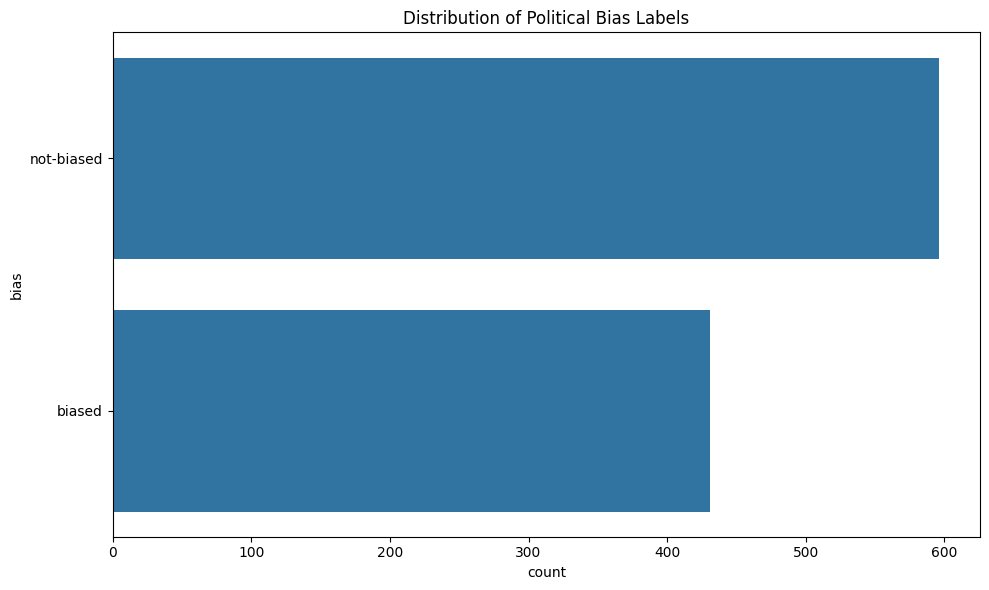

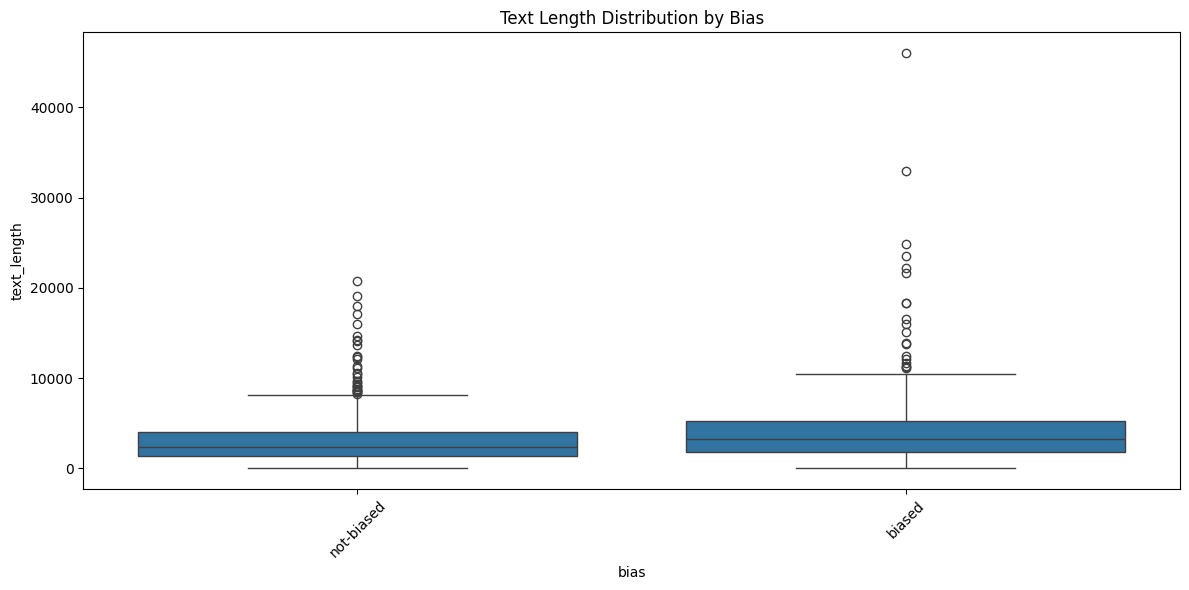

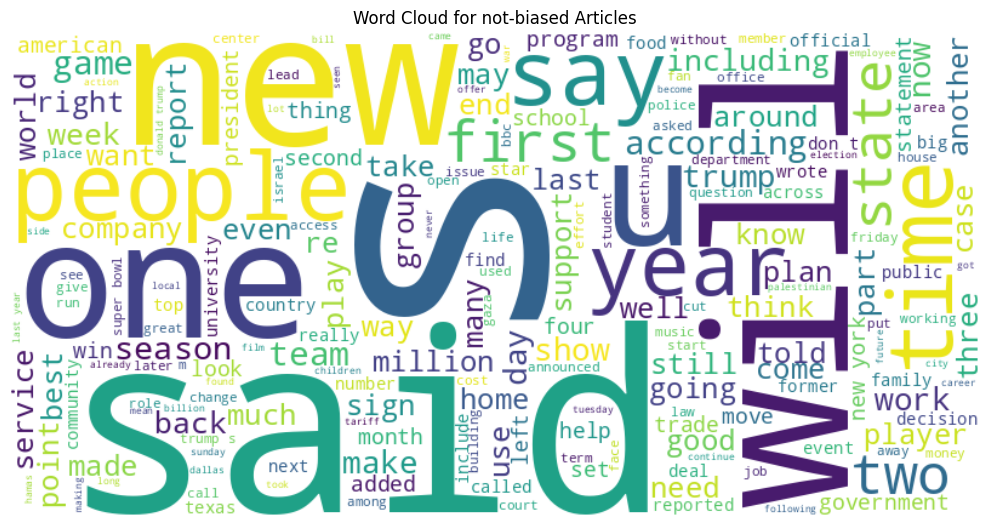

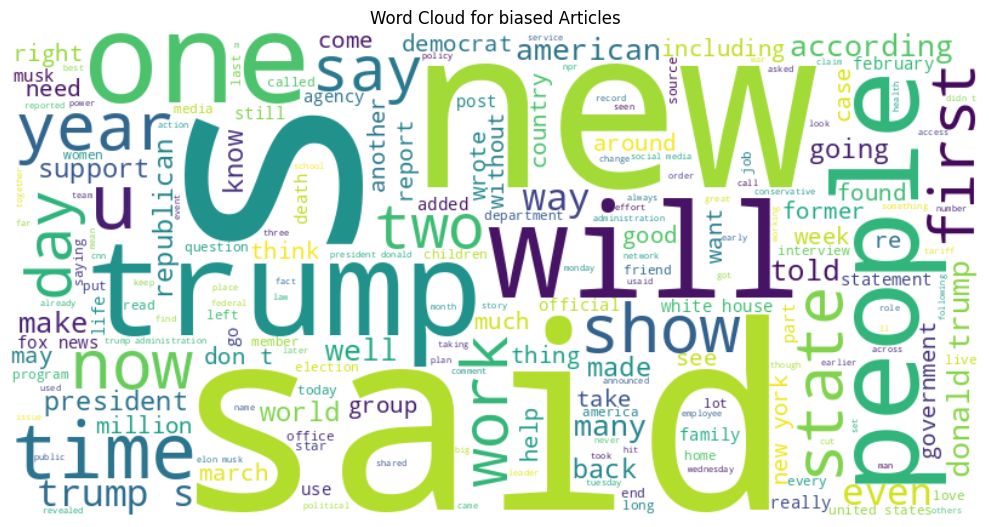

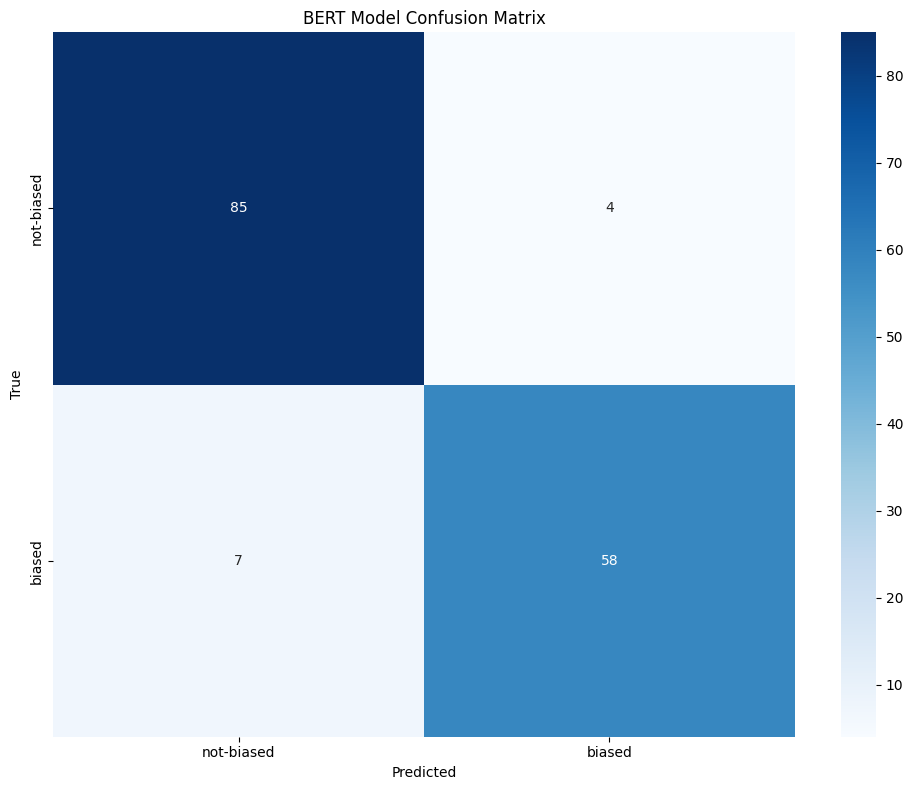

In [ ]:
"""
News Bias Classification Pipeline

This script implements a complete pipeline for classifying news articles based on their political bias.
Following the structured approach from the project outline with stages and checkpoints.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import warnings
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import random
import os
import logging
import json
from datetime import datetime

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("news_bias_classifier.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)




class NewsBiasClassifier:
    """
    End-to-end pipeline for classifying news articles based on political bias.
    """

    def __init__(self, config=None):
        """
        Initialize the classifier with configuration settings.

        Args:
            config (dict): Configuration parameters for the pipeline
        """
        # Default configuration
        self.default_config = {
            'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
            'random_seed': RANDOM_SEED,
            'model_type': 'bert',
            'bert_model': 'distilbert-base-uncased',  # Still a good fast baseline
            'max_length': 256,  # 512 is often excessive unless your articles are very long
            'batch_size': 8,                  # Best: 8
            'learning_rate': 4.5431e-05,       # Best: ~4.54e-5
            'weight_decay': 0.0701,            # Best: 0.0701
            'warmup_steps': 300,               # Best: 300
            'epochs': 10,
            'weight_decay': 0.01,  # Regularization to reduce overfitting
            'class_weights': True,

            'tfidf_params': {
                'max_features': 10000,
                'min_df': 5,
                'max_df': 0.8,
                'ngram_range': (1, 2)
            },
            'logreg_params': {
                'C': 1.0,
                'max_iter': 1000,
                'class_weight': 'balanced'
            },
            'experiment_name': f"news_bias_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        }


        # Update with user config if provided
        self.config = self.default_config.copy()
        if config:
            self.config.update(config)

        # Initialize pipeline components
        self.model = None
        self.vectorizer = None
        self.label_encoder = None
        self.experiment_results = {}

        logger.info(f"Initialized NewsBiasClassifier with config: {self.config}")

    def preprocess_text(self, text):
        """
        Clean and preprocess text data.

        Args:
            text (str): Raw text

        Returns:
            str: Cleaned text
        """
        if pd.isna(text) or not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        text = re.sub(r'Advertisement', '', text)
        text = re.sub(r'advertisement', '', text)
        text = re.sub(r'More information', '', text)
        text = re.sub(r'more information', '', text)

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def load_and_prepare_data(self, df):
        """
        Load data, perform EDA, and prepare datasets for training.

        Args:
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Dictionary containing train, validation, and test datasets
        """
        logger.info("Starting data preparation...")

        # Make a copy to avoid modifying the original dataframe
        data = df.copy()

        # Check for missing values
        missing_values = data.isnull().sum()
        logger.info(f"Missing values in dataset:\n{missing_values}")

        # Filter out rows with missing Main Text
        original_size = len(data)
        data = data.dropna(subset=['Main Text'])
        logger.info(f"Dropped {original_size - len(data)} rows with missing Main Text")

        # Convert bias labels to categories if needed
        if 'bias' in data.columns:
            # Check bias distribution
            bias_distribution = data['bias'].value_counts()
            logger.info(f"Bias label distribution:\n{bias_distribution}")

            # Create numerical encoding for bias labels
            unique_biases = data['bias'].unique()
            self.bias_categories = {bias: idx for idx, bias in enumerate(unique_biases)}
            data['bias_encoded'] = data['bias'].map(self.bias_categories)

            # Keep track of the mapping for interpretation
            self.idx_to_bias = {idx: bias for bias, idx in self.bias_categories.items()}

            logger.info(f"Encoded bias categories: {self.bias_categories}")

        # Preprocess text
        logger.info("Preprocessing text data...")
        data['processed_text'] = data['Main Text'].apply(self.preprocess_text)

        # Check text length distribution
        data['text_length'] = data['processed_text'].apply(len)

        # Split data
        train_val, test = train_test_split(
            data,
            test_size=self.config['data_split']['test'],
            random_state=self.config['random_seed'],
            stratify=data['bias_encoded'] if 'bias_encoded' in data.columns else None
        )

        train, val = train_test_split(
            train_val,
            test_size=self.config['data_split']['val'] / (self.config['data_split']['train'] + self.config['data_split']['val']),
            random_state=self.config['random_seed'],
            stratify=train_val['bias_encoded'] if 'bias_encoded' in train_val.columns else None
        )

        logger.info(f"Data split sizes - Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

        return {
            'train': train,
            'val': val,
            'test': test,
            'full_data': data
        }

    def perform_eda(self, data):
        """
        Perform Exploratory Data Analysis on the dataset.

        Args:
            data (dict): Dictionary containing data splits

        Returns:
            dict: EDA results and visualizations
        """
        logger.info("Performing Exploratory Data Analysis...")

        full_data = data['full_data']

        eda_results = {
            'dataset_info': {
                'total_samples': len(full_data),
                'bias_distribution': full_data['bias'].value_counts().to_dict() if 'bias' in full_data.columns else None,
                'text_length_stats': {
                    'mean': full_data['text_length'].mean(),
                    'median': full_data['text_length'].median(),
                    'min': full_data['text_length'].min(),
                    'max': full_data['text_length'].max()
                }
            }
        }

        logger.info(f"Dataset info:\n{json.dumps(eda_results['dataset_info'], indent=2)}")

        # Generate visualizations
        if 'bias' in full_data.columns:
            # Plot bias distribution
            plt.figure(figsize=(10, 6))
            sns.countplot(y='bias', data=full_data)
            plt.title('Distribution of Political Bias Labels')
            plt.tight_layout()
            plt.savefig('bias_distribution.png')

            # Plot text length by bias
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='bias', y='text_length', data=full_data)
            plt.title('Text Length Distribution by Bias')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('text_length_by_bias.png')

            # Generate word clouds by bias category
            for bias in full_data['bias'].unique():
                bias_text = ' '.join(full_data[full_data['bias'] == bias]['processed_text'])
                if bias_text.strip():  # Ensure there's text to process
                    wc = WordCloud(width=800, height=400, background_color='white', max_words=200)
                    wc.generate(bias_text)

                    plt.figure(figsize=(10, 6))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud for {bias} Articles')
                    plt.tight_layout()
                    plt.savefig(f'wordcloud_{bias.replace(" ", "_")}.png')

        logger.info("EDA completed and visualizations saved")
        return eda_results

    def build_tfidf_logreg_model(self):
        """
        Build a TF-IDF + Logistic Regression pipeline.

        Returns:
            sklearn.pipeline.Pipeline: Model pipeline
        """
        logger.info("Building TF-IDF + Logistic Regression model...")

        # Create TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            max_features=self.config['tfidf_params']['max_features'],
            min_df=self.config['tfidf_params']['min_df'],
            max_df=self.config['tfidf_params']['max_df'],
            ngram_range=self.config['tfidf_params']['ngram_range'],
            stop_words='english'
        )

        # Create logistic regression model
        logreg = LogisticRegression(
            C=self.config['logreg_params']['C'],
            max_iter=self.config['logreg_params']['max_iter'],
            class_weight=self.config['logreg_params']['class_weight'] if self.config['class_weights'] else None,
            random_state=self.config['random_seed']
        )

        # Create pipeline
        pipeline = Pipeline([
            ('tfidf', tfidf),
            ('logreg', logreg)
        ])

        return pipeline

    def build_bert_model(self, num_labels):
        """
        Build a BERT-based model for text classification.

        Args:
            num_labels (int): Number of target classes

        Returns:
            tuple: (tokenizer, model) for the BERT-based classifier
        """
        logger.info(f"Building BERT model ({self.config['bert_model']})...")

        # Load pre-trained tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])
        model = AutoModelForSequenceClassification.from_pretrained(
            self.config['bert_model'],
            num_labels=num_labels
        )

        return tokenizer, model

    def train_tfidf_logreg(self, train_data, val_data):
        """
        Train and evaluate the TF-IDF + Logistic Regression model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, evaluation_results)
        """
        logger.info("Training TF-IDF + Logistic Regression model...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Build and train the model
        model = self.build_tfidf_logreg_model()
        model.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        classification_rep = classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()), output_dict=True)
        conf_matrix = confusion_matrix(y_val, y_pred)

        # Log results
        logger.info(f"Validation Accuracy: {accuracy:.4f}")
        logger.info(f"Validation F1 Score (macro): {f1:.4f}")
        logger.info(f"Classification Report:\n{classification_report(y_val, y_pred, target_names=list(self.bias_categories.keys()))}")

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('tfidf_logreg_confusion_matrix.png')

        # Return the trained model and evaluation results
        results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'classification_report': classification_rep,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, results

    def train_bert(self, train_data, val_data):
        """
        Train and evaluate the BERT-based model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            tuple: (trained_model, tokenizer, evaluation_results)
        """
        logger.info("Training BERT model...")

        # Prepare the tokenizer and model
        num_labels = len(self.bias_categories)
        tokenizer, model = self.build_bert_model(num_labels)

        # Prepare the datasets
        class NewsDataset(torch.utils.data.Dataset):
            def __init__(self, texts, labels, tokenizer, max_length):
                self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                self.labels = labels

            def __getitem__(self, idx):
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)

        # Create datasets
        train_dataset = NewsDataset(
            train_data['processed_text'].tolist(),
            train_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        val_dataset = NewsDataset(
            val_data['processed_text'].tolist(),
            val_data['bias_encoded'].tolist(),
            tokenizer,
            self.config['max_length']
        )

        # Compute class weights for handling imbalance
        if self.config['class_weights']:
            class_counts = train_data['bias_encoded'].value_counts().sort_index()
            total_samples = len(train_data)
            class_weights = torch.tensor(
                [total_samples / (len(class_counts) * count) for count in class_counts],
                dtype=torch.float
            )
            logger.info(f"Class weights: {class_weights}")
        else:
            class_weights = None

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/{self.config['experiment_name']}",
            num_train_epochs=self.config['epochs'],
            per_device_train_batch_size=self.config['batch_size'],
            per_device_eval_batch_size=self.config['batch_size'],
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            learning_rate=self.config['learning_rate'],
        )

        # Define compute metrics function
        def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            f1 = f1_score(labels, preds, average='macro')
            acc = accuracy_score(labels, preds)
            return {'accuracy': acc, 'f1': f1}

        # Create trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        eval_results = trainer.evaluate()
        logger.info(f"Evaluation results: {eval_results}")

        # Make predictions for confusion matrix
        val_predictions = trainer.predict(val_dataset)
        y_pred = np.argmax(val_predictions.predictions, axis=1)
        y_true = val_data['bias_encoded'].values

        # Calculate detailed metrics
        class_report = classification_report(
            y_true, y_pred,
            target_names=list(self.bias_categories.keys()),
            output_dict=True
        )
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(self.bias_categories.keys()),
                   yticklabels=list(self.bias_categories.keys()))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('BERT Model Confusion Matrix')
        plt.tight_layout()
        plt.savefig('bert_confusion_matrix.png')

        # Return results
        results = {
            'accuracy': eval_results['eval_accuracy'],
            'f1_score': eval_results['eval_f1'],
            'classification_report': class_report,
            'confusion_matrix': conf_matrix.tolist()
        }

        return model, tokenizer, results

    def hyperparameter_tuning(self, train_data, val_data):
        """
        Perform hyperparameter tuning for the TF-IDF + LogReg model.

        Args:
            train_data (pandas.DataFrame): Training data
            val_data (pandas.DataFrame): Validation data

        Returns:
            dict: Best parameters and results
        """
        logger.info("Starting hyperparameter tuning for TF-IDF + LogReg...")

        # Get features and labels
        X_train = train_data['processed_text']
        y_train = train_data['bias_encoded']

        X_val = val_data['processed_text']
        y_val = val_data['bias_encoded']

        # Define parameter grid
        param_grid = {
            'tfidf__max_features': [5000, 10000, 15000],
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'logreg__C': [0.1, 1.0, 10.0]
        }

        # Build base model
        model = self.build_tfidf_logreg_model()

        # Set up grid search with cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.config['random_seed'])
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=cv,
            scoring='f1_macro',
            verbose=1,
            n_jobs=-1
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # Get best parameters and score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        logger.info(f"Best CV score: {best_score:.4f}")
        logger.info(f"Best parameters: {best_params}")

        # Evaluate best model on validation set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)

        val_accuracy = accuracy_score(y_val, y_pred)
        val_f1 = f1_score(y_val, y_pred, average='macro')

        logger.info(f"Validation Accuracy with best model: {val_accuracy:.4f}")
        logger.info(f"Validation F1 Score with best model: {val_f1:.4f}")

        # Update config with best parameters
        for param, value in best_params.items():
            component, parameter = param.split('__')
            if component == 'tfidf':
                self.config['tfidf_params'][parameter] = value
            elif component == 'logreg':
                self.config['logreg_params'][parameter] = value

        tuning_results = {
            'best_params': best_params,
            'best_cv_score': best_score,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        }

        return best_model, tuning_results

    def evaluate_model(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
        """
        Evaluate the trained model on the test set.

        Args:
            model: Trained model
            test_data (pandas.DataFrame): Test dataset
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            dict: Evaluation metrics
        """
        logger.info(f"Evaluating {model_type} model on test data...")

        X_test = test_data['processed_text']
        y_test = test_data['bias_encoded']

        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)

        elif model_type == 'bert':
            # For BERT model

            # Create dataset
            class NewsDataset(torch.utils.data.Dataset):
                def __init__(self, texts, labels, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                    self.labels = labels

                def __getitem__(self, idx):
                    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                    item['labels'] = torch.tensor(self.labels[idx])
                    return item

                def __len__(self):
                    return len(self.labels)

            test_dataset = NewsDataset(
                X_test.tolist(),
                y_test.tolist(),
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            test_predictions = trainer.predict(test_dataset)

            y_prob = test_predictions.predictions
            y_pred = np.argmax(y_prob, axis=1)

        # Create combined dataframe with predictions
        analysis_df = test_data.copy()
        analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
        analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
        analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

        # Find confident correct and incorrect predictions
        if model_type == 'tfidf_logreg':
            analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
        else:
            analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

        high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
        low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
        low_conf_predictions = analysis_df[analysis_df['confidence'] < 0.6]

        # Analyze potentially neutral articles
        neutral_predictions = []
        if model_type == 'tfidf_logreg':
            # If max probability is low across all classes, the article might be neutral
            for i, probs in enumerate(y_prob):
                if np.max(probs) < 0.4:  # Low confidence threshold
                    neutral_predictions.append({
                        'index': i,
                        'text': test_data.iloc[i]['Main Text'][:300] + '...',
                        'predicted_bias': self.idx_to_bias[y_pred[i]],
                        'true_bias': self.idx_to_bias[y_test.iloc[i]],
                        'confidence': np.max(probs),
                        'all_probs': {self.idx_to_bias[j]: prob for j, prob in enumerate(probs)}
                    })

        # Return qualitative analysis results
        results = {
            'general_stats': {
                'accuracy': (analysis_df['correct'].sum() / len(analysis_df)),
                'high_conf_predictions': len(analysis_df[analysis_df['confidence'] > 0.8]),
                'low_conf_predictions': len(analysis_df[analysis_df['confidence'] < 0.6]),
            },
            'examples': {
                'high_conf_correct': high_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'high_conf_incorrect': high_conf_incorrect.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'low_conf_correct': low_conf_correct.head(3)[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
                'potential_neutral': neutral_predictions[:3] if neutral_predictions else []
            }
        }

        # Log summary of findings
        logger.info("Qualitative Analysis Summary:")
        logger.info(f"  - {results['general_stats']['high_conf_predictions']} high confidence predictions (>0.8)")
        logger.info(f"  - {results['general_stats']['low_conf_predictions']} low confidence predictions (<0.6)")
        logger.info(f"  - {len(high_conf_incorrect)} predictions that are highly confident but wrong")
        logger.info(f"  - Found {len(neutral_predictions)} potentially neutral articles")

        return results

    def feature_importance(self, model, model_type='tfidf_logreg'):
        """
        Extract and analyze feature importance from the model

        Args:
            model: Trained model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            dict: Feature importance analysis
        """
        if model_type != 'tfidf_logreg':
            logger.info("Feature importance analysis is only available for TF-IDF + LogReg models")
            return None

        logger.info("Analyzing feature importance...")

        # Extract the vectorizer and classifier from the pipeline
        vectorizer = model.named_steps['tfidf']
        classifier = model.named_steps['logreg']

        # Get feature names from the vectorizer
        feature_names = vectorizer.get_feature_names_out()

        # For each class, get the most important features
        important_features = {}

        for class_id, class_name in self.idx_to_bias.items():
            # Get coefficients for this class
            if classifier.coef_.shape[0] > 1:  # multi-class case
                coefficients = classifier.coef_[class_id]
            else:  # binary case
                coefficients = classifier.coef_[0] * (1 if class_id == 1 else -1)

            # Get top positive and negative features
            top_positive_indices = np.argsort(coefficients)[-20:]
            top_negative_indices = np.argsort(coefficients)[:20]

            top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
            top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

            important_features[class_name] = {
                'top_positive': top_positive,
                'top_negative': top_negative
            }

            # Log important features
            logger.info(f"Most important features for class '{class_name}':")
            logger.info("  Top positive features:")
            for feature, coef in top_positive[::-1]:
                logger.info(f"    {feature}: {coef:.4f}")

            logger.info("  Top negative features:")
            for feature, coef in top_negative:
                logger.info(f"    {feature}: {coef:.4f}")

        # Visualize top features for each class
        for class_name, features in important_features.items():
            plt.figure(figsize=(12, 8))

            # Plot positive features
            pos_features = features['top_positive']
            pos_features.sort(key=lambda x: x[1])
            plt.barh(
                [f[0] for f in pos_features],
                [f[1] for f in pos_features],
                color='green',
                alpha=0.7
            )

            plt.title(f'Top Features for "{class_name}" Class')
            plt.xlabel('Coefficient Value')
            plt.tight_layout()
            plt.savefig(f'feature_importance_{class_name.replace(" ", "_")}.png')

        return important_features

    def run_experiment(self, experiment_config, df):
        """
        Run a complete experiment with the given configuration.

        Args:
            experiment_config (dict): Configuration for the experiment
            df (pandas.DataFrame): Input dataset

        Returns:
            dict: Experiment results
        """
        # Update configuration
        self.config.update(experiment_config)
        exp_name = self.config['experiment_name']
        logger.info(f"Starting experiment: {exp_name}")

        # Step 1: Load and prepare data
        data_splits = self.load_and_prepare_data(df)

        # Step 2: Perform EDA
        eda_results = self.perform_eda(data_splits)

        # Step 3: Train model
        if self.config['model_type'] == 'tfidf_logreg':
            # [Existing TF-IDF + LogReg code...]
            pass

        elif self.config['model_type'] == 'bert':
            # Optional: Hyperparameter tuning for BERT
            if experiment_config.get('perform_tuning', False):
                model, tokenizer, tuning_results = self.hyperparameter_tuning_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'tuning_results': tuning_results
                }
            else:
                # Regular BERT training
                model, tokenizer, train_results = self.train_bert(
                    data_splits['train'],
                    data_splits['val']
                )
                results = {
                    'model_type': 'bert',
                    'training_results': train_results
                }

            # Evaluate on test set
            test_results = self.evaluate_model(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['test_evaluation'] = test_results

            # Qualitative analysis
            qual_results = self.qualitative_analysis(
                model,
                data_splits['test'],
                model_type='bert',
                tokenizer=tokenizer
            )
            results['qualitative_analysis'] = qual_results

        # Save experiment results
        self.experiment_results[exp_name] = results

        # Save model and results
        self._save_experiment(exp_name, model, results)

        logger.info(f"Experiment {exp_name} completed")
        return results

    def _save_experiment(self, exp_name, model, results):
        """
        Save experiment model and results to disk.

        Args:
            exp_name (str): Name of the experiment
            model: Trained model
            results (dict): Experiment results
        """
        # Create directory
        os.makedirs(f"./experiments/{exp_name}", exist_ok=True)

        # Save results as JSON
        with open(f"./experiments/{exp_name}/results.json", 'w') as f:
            json.dump(results, f, indent=2, default=lambda x: str(x))

        # Save config
        with open(f"./experiments/{exp_name}/config.json", 'w') as f:
            json.dump(self.config, f, indent=2)

        # Save model
        if results['model_type'] == 'tfidf_logreg':
            import joblib
            joblib.dump(model, f"./experiments/{exp_name}/model.joblib")
        else:
            # For BERT, save the model using transformers
            model.save_pretrained(f"./experiments/{exp_name}/model")

        logger.info(f"Saved experiment {exp_name} to disk")

    def predict(self, texts, model=None, model_type=None, tokenizer=None):
        """
        Make predictions on new texts.

        Args:
            texts (list): List of text strings to predict
            model: Model to use for prediction (if None, use the last trained model)
            model_type (str): Type of model ('tfidf_logreg' or 'bert')
            tokenizer: BERT tokenizer (required if model_type is 'bert')

        Returns:
            list: Predicted bias labels and probabilities
        """
        # Use current model and type if not provided
        if model is None:
            model = self.model

        if model_type is None:
            model_type = self.config['model_type']

        # Ensure model is loaded
        if model is None:
            raise ValueError("No model available for prediction")

        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]

        # Make predictions
        if model_type == 'tfidf_logreg':
            # For sklearn pipeline
            y_prob = model.predict_proba(processed_texts)
            y_pred = model.predict(processed_texts)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: prob for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': np.max(y_prob[i])
                })

        elif model_type == 'bert':
            # For BERT model
            if tokenizer is None:
                raise ValueError("Tokenizer must be provided for BERT predictions")

            # Create dataset
            class PredictionDataset(torch.utils.data.Dataset):
                def __init__(self, texts, tokenizer, max_length):
                    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)

                def __getitem__(self, idx):
                    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

                def __len__(self):
                    return len(self.encodings['input_ids'])

            # Create dataset and make predictions
            pred_dataset = PredictionDataset(
                processed_texts,
                tokenizer,
                self.config['max_length']
            )

            # Set up trainer for prediction
            trainer = Trainer(model=model)
            predictions_output = trainer.predict(pred_dataset)

            y_prob = predictions_output.predictions
            y_pred = np.argmax(y_prob, axis=1)

            # Convert indices to bias labels
            predictions = []
            for i, pred in enumerate(y_pred):
                pred_label = self.idx_to_bias[pred]
                probs = {self.idx_to_bias[j]: float(prob) for j, prob in enumerate(y_prob[i])}
                predictions.append({
                    'text': texts[i][:100] + '...',
                    'predicted_bias': pred_label,
                    'probabilities': probs,
                    'confidence': float(np.max(y_prob[i]))
                })

        return predictions

    def deploy_model(self, model_path, model_type='tfidf_logreg'):
        """
        Load a saved model for deployment.

        Args:
            model_path (str): Path to the saved model
            model_type (str): Type of model ('tfidf_logreg' or 'bert')

        Returns:
            tuple: (model, tokenizer) - tokenizer is None for tfidf_logreg
        """
        logger.info(f"Loading {model_type} model from {model_path}")

        # Load config
        with open(os.path.join(os.path.dirname(model_path), 'config.json'), 'r') as f:
            self.config = json.load(f)

        # Load model
        if model_type == 'tfidf_logreg':
            import joblib
            model = joblib.load(model_path)
            tokenizer = None

        elif model_type == 'bert':
            # For BERT, load the model and tokenizer
            model = AutoModelForSequenceClassification.from_pretrained(model_path)
            tokenizer = AutoTokenizer.from_pretrained(model_path)

        self.model = model
        self.model_type = model_type

        logger.info(f"Model loaded successfully")
        return model, tokenizer

    def hyperparameter_tuning_bert(self, train_data, val_data):
      """
      Perform hyperparameter tuning for the BERT model using Optuna or similar.

      Args:
          train_data (pandas.DataFrame): Training data
          val_data (pandas.DataFrame): Validation data

      Returns:
          tuple: (best_model, best_tokenizer, tuning_results)
      """
      logger.info("Starting hyperparameter tuning for BERT model...")

      import optuna
      from optuna.integration import PyTorchLightningPruningCallback

      # Prepare datasets
      num_labels = len(self.bias_categories)
      tokenizer = AutoTokenizer.from_pretrained(self.config['bert_model'])

      class NewsDataset(torch.utils.data.Dataset):
          def __init__(self, texts, labels, tokenizer, max_length):
              self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
              self.labels = labels

          def __getitem__(self, idx):
              item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
              item['labels'] = torch.tensor(self.labels[idx])
              return item

          def __len__(self):
              return len(self.labels)

      train_dataset = NewsDataset(
          train_data['processed_text'].tolist(),
          train_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      val_dataset = NewsDataset(
          val_data['processed_text'].tolist(),
          val_data['bias_encoded'].tolist(),
          tokenizer,
          self.config['max_length']
      )

      def objective(trial):
          # Define hyperparameters to tune
          learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
          batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
          weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
          warmup_steps = trial.suggest_int("warmup_steps", 100, 1000, step=100)

          # Load model with current hyperparameters
          model = AutoModelForSequenceClassification.from_pretrained(
              self.config['bert_model'],
              num_labels=num_labels
          )

          # Training arguments
          training_args = TrainingArguments(
              output_dir=f"./results/{self.config['experiment_name']}/trial_{trial.number}",
              per_device_train_batch_size=batch_size,
              per_device_eval_batch_size=batch_size,
              learning_rate=learning_rate,
              weight_decay=weight_decay,
              warmup_steps=warmup_steps,
              num_train_epochs=10,  # Fewer epochs for faster tuning
              eval_strategy="epoch",
              save_strategy="epoch",
              logging_dir='./logs',
              logging_steps=10,
              load_best_model_at_end=True,
              metric_for_best_model="f1",
              greater_is_better=True,
          )

          # Define compute metrics function
          def compute_metrics(pred):
              labels = pred.label_ids
              preds = pred.predictions.argmax(-1)
              f1 = f1_score(labels, preds, average='macro')
              acc = accuracy_score(labels, preds)
              return {'accuracy': acc, 'f1': f1}

          # Create trainer
          trainer = Trainer(
              model=model,
              args=training_args,
              train_dataset=train_dataset,
              eval_dataset=val_dataset,
              compute_metrics=compute_metrics,
              data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
          )

          # Train and evaluate
          trainer.train()
          eval_results = trainer.evaluate()

          return eval_results['eval_f1']  # Optimize for F1 score

      # Create study and optimize
      study = optuna.create_study(direction="maximize")
      study.optimize(objective, n_trials=10)  # Number of trials

      # Get best hyperparameters
      best_params = study.best_params
      logger.info(f"Best hyperparameters: {best_params}")

      # Train final model with best hyperparameters
      model = AutoModelForSequenceClassification.from_pretrained(
          self.config['bert_model'],
          num_labels=num_labels
      )

      training_args = TrainingArguments(
          output_dir=f"./results/{self.config['experiment_name']}/best_model",
          per_device_train_batch_size=best_params['batch_size'],
          per_device_eval_batch_size=best_params['batch_size'],
          learning_rate=best_params['learning_rate'],
          weight_decay=best_params['weight_decay'],
          warmup_steps=best_params['warmup_steps'],
          num_train_epochs=self.config['epochs'],
          eval_strategy="epoch",
          save_strategy="epoch",
          logging_dir='./logs',
          logging_steps=10,
          load_best_model_at_end=True,
          metric_for_best_model="f1",
          greater_is_better=True,
      )

      # Define compute metrics function
      def compute_metrics(pred):
          labels = pred.label_ids
          preds = pred.predictions.argmax(-1)
          f1 = f1_score(labels, preds, average='macro')
          acc = accuracy_score(labels, preds)
          return {'accuracy': acc, 'f1': f1}

      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=val_dataset,
          compute_metrics=compute_metrics,
          data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
      )

      trainer.train()

      # Evaluate on validation set
      eval_results = trainer.evaluate()

      tuning_results = {
          'best_params': best_params,
          'best_score': study.best_value,
          'val_accuracy': eval_results['eval_accuracy'],
          'val_f1': eval_results['eval_f1'],
          'study': study.trials_dataframe().to_dict()
      }

      return model, tokenizer, tuning_results

    def qualitative_analysis(self, model, test_data, model_type='tfidf_logreg', tokenizer=None):
      """
      Perform qualitative analysis on model predictions.

      Args:
          model: Trained model
          test_data (pandas.DataFrame): Test dataset
          model_type (str): Type of model ('tfidf_logreg' or 'bert')
          tokenizer: BERT tokenizer (required if model_type is 'bert')

      Returns:
          dict: Qualitative analysis results
      """
      logger.info("Performing qualitative analysis of model predictions...")

      X_test = test_data['processed_text']
      y_test = test_data['bias_encoded']

      if model_type == 'tfidf_logreg':
          # For sklearn pipeline
          y_pred = model.predict(X_test)
          y_prob = model.predict_proba(X_test)

      elif model_type == 'bert':
          # For BERT model
          class NewsDataset(torch.utils.data.Dataset):
              def __init__(self, texts, labels, tokenizer, max_length):
                  self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
                  self.labels = labels

              def __getitem__(self, idx):
                  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                  item['labels'] = torch.tensor(self.labels[idx])
                  return item

              def __len__(self):
                  return len(self.labels)

          test_dataset = NewsDataset(
              X_test.tolist(),
              y_test.tolist(),
              tokenizer,
              self.config['max_length']
          )

          # Set up trainer for prediction
          trainer = Trainer(model=model)
          test_predictions = trainer.predict(test_dataset)

          y_prob = test_predictions.predictions
          y_pred = np.argmax(y_prob, axis=1)

      # Create combined dataframe with predictions
      analysis_df = test_data.copy()
      analysis_df['predicted_bias'] = [self.idx_to_bias[pred] for pred in y_pred]
      analysis_df['true_bias'] = [self.idx_to_bias[true] for true in y_test]
      analysis_df['correct'] = analysis_df['predicted_bias'] == analysis_df['true_bias']

      # Set confidence scores
      if model_type == 'tfidf_logreg':
          analysis_df['confidence'] = [np.max(y_prob[i]) for i in range(len(y_prob))]
      else:
          analysis_df['confidence'] = [float(np.max(y_prob[i])) for i in range(len(y_prob))]

      # Find interesting examples for analysis
      high_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      high_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)]
      low_conf_correct = analysis_df[(analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]
      low_conf_incorrect = analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] < 0.6)]

      # Analyze content patterns by categorizing articles
      category_patterns = {}
      for bias in self.idx_to_bias.values():
          # Find correctly classified articles for this bias
          correct_examples = analysis_df[(analysis_df['true_bias'] == bias) & (analysis_df['correct'])]
          # Find incorrectly classified articles for this bias
          incorrect_examples = analysis_df[(analysis_df['true_bias'] == bias) & (~analysis_df['correct'])]

          # Sample some examples
          category_patterns[bias] = {
              'correct_examples': correct_examples.sample(min(3, len(correct_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'incorrect_examples': incorrect_examples.sample(min(3, len(incorrect_examples)))[['Main Text', 'predicted_bias', 'confidence']].to_dict('records'),
              'correct_rate': len(correct_examples) / max(1, len(correct_examples) + len(incorrect_examples)),
              'avg_confidence_correct': correct_examples['confidence'].mean() if len(correct_examples) > 0 else 0,
              'avg_confidence_incorrect': incorrect_examples['confidence'].mean() if len(incorrect_examples) > 0 else 0
          }

      # Find commonly misclassified pairs
      misclassification_matrix = {}
      for true_bias in self.idx_to_bias.values():
          misclassification_matrix[true_bias] = {}
          for pred_bias in self.idx_to_bias.values():
              if true_bias != pred_bias:
                  count = len(analysis_df[(analysis_df['true_bias'] == true_bias) &
                                        (analysis_df['predicted_bias'] == pred_bias)])
                  misclassification_matrix[true_bias][pred_bias] = count

      # Find the most common misclassification pairs
      misclassification_pairs = []
      for true_bias, pred_dict in misclassification_matrix.items():
          for pred_bias, count in pred_dict.items():
              if count > 0:
                  misclassification_pairs.append({
                      'true_bias': true_bias,
                      'predicted_bias': pred_bias,
                      'count': count
                  })

      # Sort by count in descending order
      misclassification_pairs.sort(key=lambda x: x['count'], reverse=True)

      # Assemble the analysis results
      qual_results = {
          'general_stats': {
              'accuracy': analysis_df['correct'].mean(),
              'high_confidence_accuracy': high_conf_correct.shape[0] / max(1, high_conf_correct.shape[0] + high_conf_incorrect.shape[0]),
              'low_confidence_accuracy': low_conf_correct.shape[0] / max(1, low_conf_correct.shape[0] + low_conf_incorrect.shape[0]),
              'avg_confidence': analysis_df['confidence'].mean(),
              'avg_confidence_correct': analysis_df[analysis_df['correct']]['confidence'].mean(),
              'avg_confidence_incorrect': analysis_df[~analysis_df['correct']]['confidence'].mean()
          },
          'examples': {
              'high_conf_correct': high_conf_correct.sample(min(3, len(high_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'high_conf_incorrect': high_conf_incorrect.sample(min(3, len(high_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_correct': low_conf_correct.sample(min(3, len(low_conf_correct)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records'),
              'low_conf_incorrect': low_conf_incorrect.sample(min(3, len(low_conf_incorrect)))[['Main Text', 'true_bias', 'predicted_bias', 'confidence']].to_dict('records')
          },
          'bias_patterns': category_patterns,
          'misclassification_pairs': misclassification_pairs[:5]  # Top 5 most common misclassifications
      }

      # Log a summary of the qualitative analysis
      logger.info("Qualitative Analysis Summary:")
      logger.info(f"Overall accuracy: {qual_results['general_stats']['accuracy']:.4f}")
      logger.info(f"High confidence accuracy: {qual_results['general_stats']['high_confidence_accuracy']:.4f}")
      logger.info(f"Low confidence accuracy: {qual_results['general_stats']['low_confidence_accuracy']:.4f}")
      logger.info(f"Average confidence: {qual_results['general_stats']['avg_confidence']:.4f}")

      # Top misclassifications
      logger.info("Top misclassification pairs:")
      for pair in qual_results['misclassification_pairs']:
          logger.info(f"  {pair['true_bias']} → {pair['predicted_bias']}: {pair['count']} instances")

      return qual_results

# Usage example
def main():
    """
    Main function to demonstrate the news bias classifier pipeline.
    """


    """
    # Sample configuration
    config = {
        'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
        'experiment_name': 'news_bias_demo',
        'random_seed': 11,
        'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
        'class_weights': True,
        'perform_tuning': True,
        'tfidf_params': {
            'max_features': 10000,
            'min_df': 5,
            'max_df': 0.8,
            'ngram_range': (1, 2)
        },
        'logreg_params': {
            'C': 1.0,
            'max_iter': 1000,
            'class_weight': 'balanced'
        }
    }

    # Sample usage
    classifier = NewsBiasClassifier(config)

    # For demonstration:
    classifier.run_experiment(config, df)
    print(classifier.experiment_results)
    """



  #################################################### 2nd df ####################################################


    df_generalized = df.copy()

    # Generalize center-leaning labels
    df_generalized['bias'] = df_generalized['bias'].replace({
        'left': 'biased',
        'right': 'biased',
        'center': 'not-biased'
    })

    df_generalized = df_generalized[~df_generalized['bias'].isin(['left-center', 'right-center'])]


    config = {
          'model_type': 'bert',  # 'tfidf_logreg' or 'bert'
          'experiment_name': 'news_bias_demo_2',
          'random_seed': 42,
          'data_split': {'train': 0.7, 'val': 0.15, 'test': 0.15},
          'class_weights': True,
          'perform_tuning': False,
          'tfidf_params': {
              'max_features': 10000,
              'min_df': 5,
              'max_df': 0.8,
              'ngram_range': (1, 2)
          },
          'logreg_params': {
              'C': 1.0,
              'max_iter': 1000,
              'class_weight': 'balanced'
          }

      }

    # Sample usage
    classifier = NewsBiasClassifier()

    # For demonstration:
    classifier.run_experiment(config, df_generalized)
    print(classifier.experiment_results)


if __name__ == "__main__":
    main()